In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#!pip install fast-tsp
#!pip install shapely
#!pip install https://vrpy.readthedocs.io/en/latest/how_to.html

import fast_tsp
import pickle
#from google.colab import files
# https://stackoverflow.com/questions/71196078/scalable-implementation-of-tsp-in-python

#gurobipy
#!pip install gurobipy
import gurobipy as gp
# Create an environment with your WLS license
#params = {
#"WLSACCESSID": '1acf074f-38af-48b5-acd0-fe8bd12349df',
#"WLSSECRET": '3ff35e2d-cfa2-46f3-8977-2a5a1e4d078c',
#"LICENSEID": 2420854,
#}
#gurobipyenv = gp.Env(params=params)
# Create the model within the Gurobi environment
#model = gp.Model(env=gurobipyenv)

import time

#%cd "/content/drive/MyDrive/projects/23WSmart/h"

Modelo Joana

In [ ]:
# @title
# -*- coding: utf-8 -*-

import gurobipy as gp
import pandas as pd

def policy_gurobi(bins, distancematrix, param, media, desviopadrao, timeLimit = 60):
    
    print(bins)
    
    new_distances = distancematrix[0]

    for i in range(len(distancematrix)):
        distancematrix[i].append(new_distances[i])

    distancematrix.append(new_distances)

    # MUST GO
    pred_must_go = []
    for container_id in range(0,len(bins)):
        pred_value = (bins[container_id] + media[container_id] + param * desviopadrao[container_id])
        pred_must_go.append(pred_value)

    #alterei para +1
    I = set(range(0,len(bins)+2))
    RNR = set(list(I)[1:-1])

    MG = set()
    for container_id in range(0,len(bins)):
        if pred_must_go[container_id] >= 100:
            MG.add(container_id+1)

    # w1 em kg
    # DENSIDADE DO PAPEL = 29.5
    w1 = [(((w * 2500)/100)*29.5)/1000 for w in bins]

    price = 0.121
    cost = 1
    cap = 4000
    pen = 0.1
    #k = 1 # número de veículos

    dist = {(i, j): distancematrix[i][j] for i in I for j in I}
    waste = {i: w1[i-1] for i in RNR}

    mdl = gp.Model('VRPP')
    #non verbose
    mdl.Params.LogToConsole = 0


    X = [(i,j) for i in I for j in I if i != j]
    x = mdl.addVars(X, vtype=gp.GRB.BINARY, name="x")
    Y = [(i,j) for i in I for j in I if i != j]
    y = mdl.addVars(Y, vtype=gp.GRB.CONTINUOUS, name="y")
    G = [i for i in I if i != 0 and i != list(I)[-1]]
    g = mdl.addVars(G, vtype=gp.GRB.BINARY, name="g")
    k = mdl.addVar(vtype=gp.GRB.INTEGER, name="k")


    mdl.Params.FeasibilityTol = 1e-09

    # Tempo limite para o modelo correr
    mdl.Params.TimeLimit = timeLimit

    mdl.modelsense = gp.GRB.MAXIMIZE

    mdl.setObjective(price * gp.quicksum(waste[(i)]*g[(i)] for i in RNR) - ((cost/2)*gp.quicksum(gp.quicksum(x[(i,j)]*dist[(i,j)] for j in I if i != j) for i in I) + pen * k))

    #constraints (numeração Manuscript)
    #4
    mdl.addConstrs(gp.quicksum(y[i,j]-y[j,i] for j in I if j != i) == 2*waste[(i)]*g[(i)] for i in RNR)
    print('Constraint 1')
    #5
    mdl.addConstrs(gp.quicksum(y[i,j] for i in RNR) == gp.quicksum(waste[(i)]*g[(i)] for i in RNR) for j in I if j == list(I)[-1])
    print('Constraint 2')
    #6
    mdl.addConstrs(gp.quicksum(y[j,i] for i in RNR) == cap*k - gp.quicksum(waste[(i)]*g[(i)] for i in RNR) for j in I if j == list(I)[-1])
    print('Constraint 3')
    #7
    mdl.addConstrs(gp.quicksum(y[j,i] for j in RNR) <= cap*k for i in I if i == 0)
    print('Constraint 4')
    #8
    mdl.addConstrs(gp.quicksum(y[i,j] for j in RNR) == 0 for i in I if i == 0)
    print('Constraint 5')
    #9
    mdl.addConstrs(gp.quicksum(x[i,j] for i in I if i != j) == 2*g[(j)] for j in RNR)
    print('Constraint 6')
    #10
    mdl.addConstrs(y[i,j] + y[j,i] == cap*x[i,j] for i in I for j in I if i != j)
    print('Constraint 7')
    # Must Go
    mdl.addConstrs(g[(i)] == 1 for i in MG)
    print('Constraint 8')


    try:
        mdl.optimize()

        print('Model status:', mdl.status)

        print("Value of k:", k.X)
        for i in G:
            print(f"g[{i}] = {g[i].X}")

        # print('The optimal solution is:', mdl.ObjVal)
        # print('The runtime is:', mdl.runtime)

        g_values = {i: g[i].x for i in g.keys()}
        # lista de contentores visitados
        visited_containers = [i for i, value in g_values.items() if value > 0.5]

        return visited_containers

    except gp.GurobiError as e:
        print('Model status:', mdl.status)
        print("Optimization failed. Error message:", str(e))
        return None




#Exemplo

# bins=[37.5,12.5,37.5,37.5,87.5]

# media=[60.7125,
#        69.6375,
#        69.6375,
#        55.3625,
#        64.0625]

# desviopadrao=[19.29,
#               23.15,
#               16.90,
#               16.90,
#               23.22]
# param=0.84

# distancematrix=[[0,38.76,3.53,5.17,1.78,1.9,0],
#                 [38.82,0,3.6,5.23,1.85,1.96,0.89],
#                 [38.42,38.42,0,5.57,2.19,2.3,1.22],
#                 [38.7,38.7,3.38,0,1.63,1.75,0.67],
#                 [38.9,38.9,3.38,5.02,0,1.75,0.67],
#                 [39.24,39.24,3.89,5.53,2.14,0,1.18],
#                 [0,39.61,4.26,5.9,2.51,2.63,0]]

# results = policy_gurobi(bins, distancematrix, param, media, desviopadrao,timeLimit=60)
# print("Visited containers",results)







Modelo Diana

In [ ]:
# @title

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gamma

from  statsmodels.distributions.empirical_distribution import ECDF

np.set_printoptions(precision=2)

def predictdaystooverflow(ui,vi,f,cl):

    n = np.zeros(ui.shape[0])+31

    for ii in np.arange(1,31,1):
        k = ii*ui**2/vi
        th = vi/ui
        aux = np.zeros(ui.shape[0])+31
        p = 1-gamma.cdf(100-f, k, scale=th)
        aux[np.nonzero(p>cl)[0]]=ii
        print(aux,p)
        n = np.minimum(n,aux)

        if (p>cl).all():
            return n

def freqvisit(ui,vi,cf):

    p = 0
    z = 1
    z0 = 1
    for n in range(1,100):
        k = n*ui**2/vi
        th = vi/ui

        z = 1-gamma.cdf(100,k,scale=th)

        p += z+(1-z0)*z
        z0 *= (1-z)
        #print(n,1-gamma.cdf(100,k,scale=th)               ,p)
        if p>cf:
            return n-1


def freqvisit2(ui,vi,cf):
    # a = gamma.cdf(30, k, scale=th)
    # c = gamma.ppf(a, k, scale=th)
    # print(a,c)


    for n in range(1,50):
        k = n*ui**2/vi
        th = vi/ui
        if n==1:
            ov = 100-gamma.ppf(1-cf, k, scale=th)

        v = gamma.ppf(1-cf, k, scale=th)

        if v>100:

            return n, ov


def sample(ui,vi,n=10):

        k = ui**2/vi
        th = vi/ui
        L = []
        M = []
        for ii in range(n):
            m = 0
            om = 0
            d = 0
            while m<100:
                om = m
                m += np.random.gamma(k,scale=th)
                d += 1
            L.append(d)
            M.append(om)

        return np.array(L), np.array(M)

def verifylv2(ui,vi,lv2,n=10):

        k = ui**2/vi
        th = vi/ui
        L = []
        M = []
        for ii in range(n):
            m = 0
            om = 0
            d = 0
            while m<lv2:
                om = m
                m += np.random.gamma(k,scale=th)
                d += 1
            L.append(d)
            M.append(om)

        return np.array(L), np.array(M)

# N = 10000
# for ui in [5,10,20]:#range(5,55,10):

#     for vi in [10,25,50]:#range(5,95,10):
#         k = ui**2/vi
#         th = vi/ui
#         #f = freqvisit(ui,vi,0.9)
#         f2,lv2 = freqvisit2(ui,vi,0.9)
#         f3,lv3 = freqvisit2(ui,vi,0.7)
#         verd,verM = verifylv2(ui,vi,lv2,n=10)
#         d,M = sample(ui,vi,n=N)
#         d.sort()
#         M.sort()
#         ecdf = ECDF(d)
#         ecdfm = ECDF(M)


#         print(ui,vi,"f2",f2,lv2,"f3",f3,lv3,
#               ecdf.x[np.nonzero(ecdf.y>0.9)[0][0]],
#               ecdfm.x[np.nonzero(ecdfm.y>0.1)[0][0]],
#               len(np.nonzero(verd>f2)[0]),len(np.nonzero(verM>lv2)[0])
#               )
#     print("\n")

# verd,verM = verifylv2(ui,vi,lv2,n=10)

In [ ]:
# @title
import pandas as pd
import numpy as np
#from haversine import haversine
import math
from random import randint
import random
import copy
from shapely.geometry import LineString

#Functions

def create_points(data, bins_coordinates):
    points = []
    pair_lng_lat = []

    for index, row in data.iterrows():
        lat = bins_coordinates['Lat'][index]
        lng = bins_coordinates['Lng'][index]
        pair_lng_lat = []
        pair_lng_lat.append(lng)
        pair_lng_lat.append(lat)
        points.append(pair_lng_lat)

    return points

def compute_distance_matrix(bins_coordinates):
    distance_matrix = np.zeros((n_bins, n_bins))
    for index, row in bins_coordinates.iterrows():
        for index1, row1 in bins_coordinates.iterrows():
            dist = 86.51*1.58*math.sqrt((row['Lat'] - row1['Lat'])**2+(row['Lng']-row1['Lng'])**2)
            distance_matrix[index][index1] = round(dist, 10)

    return distance_matrix

#function to move 1 route (Choose one route and move one bin from one place in the route to another place in the route)
def move_1_route(routes_list):
    if len(routes_list) > 0:
        chosen_route = random.sample(routes_list,1)[0]

        if len(chosen_route) > 3:
            bin_to_move = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]

            position_bin = bin_to_move
            while position_bin == bin_to_move:
                position_bin = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
            position = chosen_route.index(position_bin)

            chosen_route.remove(bin_to_move)
            chosen_route.insert(position, bin_to_move)

#function to swap in 1 route (Choose one route, pick two bins from the route and swap them)
def swap_1_route(routes_list):
    if len(routes_list) > 0:
        chosen_route = random.sample(routes_list,1)[0]

        if len(chosen_route) > 3:
            swap_bin_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
            position_bin_1 = chosen_route.index(swap_bin_1)

            swap_bin_2 = swap_bin_1
            while swap_bin_2 == swap_bin_1:
                swap_bin_2 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
            position_bin_2 = chosen_route.index(swap_bin_2)

            chosen_route[position_bin_1],chosen_route[position_bin_2] = chosen_route[position_bin_2],chosen_route[position_bin_1]

#function to move one bin from one route to another route (Choose two routes and move one element from one route to the other route)
def move_2_routes(routes_list):
    if len(routes_list) > 0:
        if len(routes_list) > 1:
            chosen_route_1 = random.sample(routes_list,1)[0]

            chosen_route_2 = chosen_route_1
            while chosen_route_2 == chosen_route_1:
                chosen_route_2 = random.sample(routes_list,1)[0]

            two_routes = []
            two_routes.append(chosen_route_1)
            two_routes.append(chosen_route_2)

            donor_route = random.sample(two_routes,1)[0]
            donor_route_index = set([two_routes.index(donor_route)])

            indexes = set([0,1])

            receptor_route_index = list(indexes - donor_route_index)[0]

            receptor_route = two_routes[receptor_route_index]

            donor_bin = random.sample(donor_route[1:len(donor_route)-1],1)[0]

            receptor_position = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

            donor_route.remove(donor_bin)
            receptor_route.insert(receptor_position, donor_bin)

            if len(donor_route) == 2:
                routes_list.remove(donor_route)

        routes_list = list(filter(None, routes_list))

#function to swap two bins between two different routes (Choose two routes and swap two bins between routes)
def swap_2_routes(routes_list):
    if len(routes_list) > 1:
        chosen_route_1 = random.sample(routes_list,1)[0]

        chosen_route_2 = chosen_route_1
        while chosen_route_2 == chosen_route_1:
            chosen_route_2 = random.sample(routes_list,1)[0]

        bin_1 = random.sample(chosen_route_1[1:len(chosen_route_1)-1],1)[0]
        bin_1_position = chosen_route_1.index(bin_1)

        bin_2 = random.sample(chosen_route_2[1:len(chosen_route_2)-1],1)[0]
        bin_2_position = chosen_route_2.index(bin_2)

        chosen_route_1[bin_1_position],chosen_route_2[bin_2_position] = chosen_route_2[bin_2_position],chosen_route_1[bin_1_position]

#function to remove one bin from one route (Drop one bin from one random chosen route)
def remove_bin(routes_list, removed_bins, bins_cannot_removed):
    bin_to_remove = None
    if len(routes_list) > 0:
        chosen_route = random.sample(routes_list,1)[0]

        if len(chosen_route) > len(bins_cannot_removed) + 2:
            if len(bins_cannot_removed) > 0:
                bin_to_remove = random.sample(bins_cannot_removed,1)[0]
                i = 0
                while bin_to_remove in bins_cannot_removed: #and i <= len(chosen_route):
                    bin_to_remove = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                    i += 1
            else:
                bin_to_remove = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]

            removed_bins.append(bin_to_remove)
            chosen_route.remove(bin_to_remove)

        if len(chosen_route) == 2:
            routes_list.remove(chosen_route)

        routes_list = list(filter(None, routes_list))

    return bin_to_remove

#function to add bin from the removed bins set to one route (Add one bin from the removed bins set to one random chosen route)
def add_bin(routes_list, removed_bins):
    if len(routes_list) > 0:
        if len(removed_bins) > 0:
            bin_to_add = random.sample(removed_bins,1)[0]

            chosen_route = random.sample(routes_list,1)[0]

            chosen_position = chosen_route.index(random.sample(chosen_route[1:len(chosen_route)-1],1)[0])

            chosen_route.insert(chosen_position, bin_to_add)

            removed_bins.remove(bin_to_add)

            return bin_to_add

#function to move n random bins inside a route
def move_n_route_random(routes_list):
    chosen_n = None
    if len(routes_list) > 0:
        chosen_route = random.sample(routes_list,1)[0]
        possible_n = [2,3,4,5]
        chosen_n = random.sample(possible_n,1)[0]

        if len(chosen_route) > chosen_n + 2:
            if chosen_n == 2:
                bin_to_move_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                bin_to_move_2 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]

                position_bin_1 = bin_to_move_1
                while position_bin_1 == bin_to_move_1:
                    position_bin_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_1 = chosen_route.index(position_bin_1)

                position_bin_2 = bin_to_move_2
                while position_bin_2 == bin_to_move_2:
                    position_bin_2 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_2 = chosen_route.index(position_bin_2)

                chosen_route.remove(bin_to_move_1)
                chosen_route.insert(position_1, bin_to_move_1)
                chosen_route.remove(bin_to_move_2)
                chosen_route.insert(position_2, bin_to_move_2)
            elif chosen_n == 3:
                bin_to_move_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                bin_to_move_2 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                bin_to_move_3 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]

                position_bin_1 = bin_to_move_1
                while position_bin_1 == bin_to_move_1:
                    position_bin_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_1 = chosen_route.index(position_bin_1)

                position_bin_2 = bin_to_move_2
                while position_bin_2 == bin_to_move_2:
                    position_bin_2 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_2 = chosen_route.index(position_bin_2)

                position_bin_3 = bin_to_move_3
                while position_bin_3 == bin_to_move_3:
                    position_bin_3 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_3 = chosen_route.index(position_bin_3)

                chosen_route.remove(bin_to_move_1)
                chosen_route.insert(position_1, bin_to_move_1)
                chosen_route.remove(bin_to_move_2)
                chosen_route.insert(position_2, bin_to_move_2)
                chosen_route.remove(bin_to_move_3)
                chosen_route.insert(position_3, bin_to_move_3)
            elif chosen_n == 4:
                bin_to_move_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                bin_to_move_2 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                bin_to_move_3 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                bin_to_move_4 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]

                position_bin_1 = bin_to_move_1
                while position_bin_1 == bin_to_move_1:
                    position_bin_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_1 = chosen_route.index(position_bin_1)

                position_bin_2 = bin_to_move_2
                while position_bin_2 == bin_to_move_2:
                    position_bin_2 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_2 = chosen_route.index(position_bin_2)

                position_bin_3 = bin_to_move_3
                while position_bin_3 == bin_to_move_3:
                    position_bin_3 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_3 = chosen_route.index(position_bin_3)

                position_bin_4 = bin_to_move_4
                while position_bin_4 == bin_to_move_4:
                    position_bin_4 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_4 = chosen_route.index(position_bin_4)

                chosen_route.remove(bin_to_move_1)
                chosen_route.insert(position_1, bin_to_move_1)
                chosen_route.remove(bin_to_move_2)
                chosen_route.insert(position_2, bin_to_move_2)
                chosen_route.remove(bin_to_move_3)
                chosen_route.insert(position_3, bin_to_move_3)
                chosen_route.remove(bin_to_move_4)
                chosen_route.insert(position_4, bin_to_move_4)
            else:
                bin_to_move_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                bin_to_move_2 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                bin_to_move_3 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                bin_to_move_4 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                bin_to_move_5 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]

                position_bin_1 = bin_to_move_1
                while position_bin_1 == bin_to_move_1:
                    position_bin_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_1 = chosen_route.index(position_bin_1)

                position_bin_2 = bin_to_move_2
                while position_bin_2 == bin_to_move_2:
                    position_bin_2 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_2 = chosen_route.index(position_bin_2)

                position_bin_3 = bin_to_move_3
                while position_bin_3 == bin_to_move_3:
                    position_bin_3 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_3 = chosen_route.index(position_bin_3)

                position_bin_4 = bin_to_move_4
                while position_bin_4 == bin_to_move_4:
                    position_bin_4 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_4 = chosen_route.index(position_bin_4)

                position_bin_5 = bin_to_move_5
                while position_bin_5 == bin_to_move_5:
                    position_bin_5 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_5 = chosen_route.index(position_bin_5)

                chosen_route.remove(bin_to_move_1)
                chosen_route.insert(position_1, bin_to_move_1)
                chosen_route.remove(bin_to_move_2)
                chosen_route.insert(position_2, bin_to_move_2)
                chosen_route.remove(bin_to_move_3)
                chosen_route.insert(position_3, bin_to_move_3)
                chosen_route.remove(bin_to_move_4)
                chosen_route.insert(position_4, bin_to_move_4)
                chosen_route.remove(bin_to_move_5)
                chosen_route.insert(position_5, bin_to_move_5)

    return chosen_n

#function to move n consecutive bins inside a route
def move_n_route_consecutive(routes_list):
    chosen_n = None
    if len(routes_list) > 0:
        chosen_route = random.sample(routes_list,1)[0]
        possible_n = [2,3,4,5]
        chosen_n = random.sample(possible_n,1)[0]

        if len(chosen_route) > chosen_n + 2:
            if chosen_n == 2:
                bin_to_move_1 = random.sample(chosen_route[1:len(chosen_route)-2],1)[0]
                bin_1_position = chosen_route.index(bin_to_move_1)
                bin_to_move_2 = chosen_route[bin_1_position + 1]

                chosen_route.remove(bin_to_move_1)
                chosen_route.remove(bin_to_move_2)

                position_bin_1 = bin_to_move_1
                while position_bin_1 == bin_to_move_1:
                    position_bin_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_1 = chosen_route.index(position_bin_1)

                chosen_route.insert(position_1, bin_to_move_1)
                chosen_route.insert(position_1 + 1, bin_to_move_2)
            elif chosen_n == 3:
                bin_to_move_1 = random.sample(chosen_route[1:len(chosen_route)-3],1)[0]
                bin_1_position = chosen_route.index(bin_to_move_1)
                bin_to_move_2 = chosen_route[bin_1_position + 1]
                bin_to_move_3 = chosen_route[bin_1_position + 2]

                chosen_route.remove(bin_to_move_1)
                chosen_route.remove(bin_to_move_2)
                chosen_route.remove(bin_to_move_3)

                position_bin_1 = bin_to_move_1
                while position_bin_1 == bin_to_move_1:
                    position_bin_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_1 = chosen_route.index(position_bin_1)

                chosen_route.insert(position_1, bin_to_move_1)
                chosen_route.insert(position_1 + 1, bin_to_move_2)
                chosen_route.insert(position_1 + 2, bin_to_move_3)
            elif chosen_n == 4:
                bin_to_move_1 = random.sample(chosen_route[1:len(chosen_route)-4],1)[0]
                bin_1_position = chosen_route.index(bin_to_move_1)
                bin_to_move_2 = chosen_route[bin_1_position + 1]
                bin_to_move_3 = chosen_route[bin_1_position + 2]
                bin_to_move_4 = chosen_route[bin_1_position + 3]

                chosen_route.remove(bin_to_move_1)
                chosen_route.remove(bin_to_move_2)
                chosen_route.remove(bin_to_move_3)
                chosen_route.remove(bin_to_move_4)

                position_bin_1 = bin_to_move_1
                while position_bin_1 == bin_to_move_1:
                    position_bin_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_1 = chosen_route.index(position_bin_1)

                chosen_route.insert(position_1, bin_to_move_1)
                chosen_route.insert(position_1 + 1, bin_to_move_2)
                chosen_route.insert(position_1 + 2, bin_to_move_3)
                chosen_route.insert(position_1 + 3, bin_to_move_4)
            else:
                bin_to_move_1 = random.sample(chosen_route[1:len(chosen_route)-5],1)[0]
                bin_1_position = chosen_route.index(bin_to_move_1)
                bin_to_move_2 = chosen_route[bin_1_position + 1]
                bin_to_move_3 = chosen_route[bin_1_position + 2]
                bin_to_move_4 = chosen_route[bin_1_position + 3]
                bin_to_move_5 = chosen_route[bin_1_position + 4]

                chosen_route.remove(bin_to_move_1)
                chosen_route.remove(bin_to_move_2)
                chosen_route.remove(bin_to_move_3)
                chosen_route.remove(bin_to_move_4)
                chosen_route.remove(bin_to_move_5)

                position_bin_1 = bin_to_move_1
                while position_bin_1 == bin_to_move_1:
                    position_bin_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_1 = chosen_route.index(position_bin_1)

                chosen_route.insert(position_1, bin_to_move_1)
                chosen_route.insert(position_1 + 1, bin_to_move_2)
                chosen_route.insert(position_1 + 2, bin_to_move_3)
                chosen_route.insert(position_1 + 3, bin_to_move_4)
                chosen_route.insert(position_1 + 4, bin_to_move_5)

    return chosen_n

#function to swap n random bins inside a route
def swap_n_route_random(routes_list):
    chosen_n = None
    if len(routes_list) > 0:
        chosen_route = random.sample(routes_list,1)[0]
        possible_n = [2,3,4,5]
        chosen_n = random.sample(possible_n,1)[0]

        if len(chosen_route) > chosen_n + 2:
            if chosen_n == 2:
                swap_bin_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_1 = chosen_route.index(swap_bin_1)

                swap_bin_2 = swap_bin_1
                while swap_bin_2 == swap_bin_1:
                    swap_bin_2 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_2 = chosen_route.index(swap_bin_2)

                chosen_route[position_bin_1],chosen_route[position_bin_2] = chosen_route[position_bin_2],chosen_route[position_bin_1]

                swap_bin_3 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_3 = chosen_route.index(swap_bin_3)

                swap_bin_4 = swap_bin_3
                while swap_bin_4 == swap_bin_3:
                    swap_bin_4 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_4 = chosen_route.index(swap_bin_4)

                chosen_route[position_bin_3],chosen_route[position_bin_4] = chosen_route[position_bin_4],chosen_route[position_bin_3]
            elif chosen_n == 3:
                swap_bin_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_1 = chosen_route.index(swap_bin_1)

                swap_bin_2 = swap_bin_1
                while swap_bin_2 == swap_bin_1:
                    swap_bin_2 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_2 = chosen_route.index(swap_bin_2)

                chosen_route[position_bin_1],chosen_route[position_bin_2] = chosen_route[position_bin_2],chosen_route[position_bin_1]

                swap_bin_3 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_3 = chosen_route.index(swap_bin_3)

                swap_bin_4 = swap_bin_3
                while swap_bin_4 == swap_bin_3:
                    swap_bin_4 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_4 = chosen_route.index(swap_bin_4)

                chosen_route[position_bin_3],chosen_route[position_bin_4] = chosen_route[position_bin_4],chosen_route[position_bin_3]

                swap_bin_5 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_5 = chosen_route.index(swap_bin_5)

                swap_bin_6 = swap_bin_5
                while swap_bin_6 == swap_bin_5:
                    swap_bin_6 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_6 = chosen_route.index(swap_bin_6)

                chosen_route[position_bin_5],chosen_route[position_bin_6] = chosen_route[position_bin_6],chosen_route[position_bin_5]
            elif chosen_n == 4:
                swap_bin_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_1 = chosen_route.index(swap_bin_1)

                swap_bin_2 = swap_bin_1
                while swap_bin_2 == swap_bin_1:
                    swap_bin_2 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_2 = chosen_route.index(swap_bin_2)

                chosen_route[position_bin_1],chosen_route[position_bin_2] = chosen_route[position_bin_2],chosen_route[position_bin_1]

                swap_bin_3 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_3 = chosen_route.index(swap_bin_3)

                swap_bin_4 = swap_bin_3
                while swap_bin_4 == swap_bin_3:
                    swap_bin_4 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_4 = chosen_route.index(swap_bin_4)

                chosen_route[position_bin_3],chosen_route[position_bin_4] = chosen_route[position_bin_4],chosen_route[position_bin_3]

                swap_bin_5 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_5 = chosen_route.index(swap_bin_5)

                swap_bin_6 = swap_bin_5
                while swap_bin_6 == swap_bin_5:
                    swap_bin_6 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_6 = chosen_route.index(swap_bin_6)

                chosen_route[position_bin_5],chosen_route[position_bin_6] = chosen_route[position_bin_6],chosen_route[position_bin_5]

                swap_bin_7 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_7 = chosen_route.index(swap_bin_7)

                swap_bin_8 = swap_bin_7
                while swap_bin_8 == swap_bin_7:
                    swap_bin_8 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_8 = chosen_route.index(swap_bin_8)

                chosen_route[position_bin_7],chosen_route[position_bin_8] = chosen_route[position_bin_8],chosen_route[position_bin_7]
            else:
                swap_bin_1 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_1 = chosen_route.index(swap_bin_1)

                swap_bin_2 = swap_bin_1
                while swap_bin_2 == swap_bin_1:
                    swap_bin_2 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_2 = chosen_route.index(swap_bin_2)

                chosen_route[position_bin_1],chosen_route[position_bin_2] = chosen_route[position_bin_2],chosen_route[position_bin_1]

                swap_bin_3 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_3 = chosen_route.index(swap_bin_3)

                swap_bin_4 = swap_bin_3
                while swap_bin_4 == swap_bin_3:
                    swap_bin_4 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_4 = chosen_route.index(swap_bin_4)

                chosen_route[position_bin_3],chosen_route[position_bin_4] = chosen_route[position_bin_4],chosen_route[position_bin_3]

                swap_bin_5 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_5 = chosen_route.index(swap_bin_5)

                swap_bin_6 = swap_bin_5
                while swap_bin_6 == swap_bin_5:
                    swap_bin_6 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_6 = chosen_route.index(swap_bin_6)

                chosen_route[position_bin_5],chosen_route[position_bin_6] = chosen_route[position_bin_6],chosen_route[position_bin_5]

                swap_bin_7 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_7 = chosen_route.index(swap_bin_7)

                swap_bin_8 = swap_bin_7
                while swap_bin_8 == swap_bin_7:
                    swap_bin_8 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_8 = chosen_route.index(swap_bin_8)

                chosen_route[position_bin_7],chosen_route[position_bin_8] = chosen_route[position_bin_8],chosen_route[position_bin_7]

                swap_bin_9 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_9 = chosen_route.index(swap_bin_9)

                swap_bin_10 = swap_bin_9
                while swap_bin_10 == swap_bin_9:
                    swap_bin_10 = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                position_bin_10 = chosen_route.index(swap_bin_10)

                chosen_route[position_bin_9],chosen_route[position_bin_10] = chosen_route[position_bin_10],chosen_route[position_bin_9]

    return chosen_n

#function to swap n random bins inside a route
def swap_n_route_consecutive(routes_list):
    chosen_n = None
    if len(routes_list) > 0:
        chosen_route = random.sample(routes_list,1)[0]
        possible_n = [2,3,4,5]
        chosen_n = random.sample(possible_n,1)[0]

        if len(chosen_route) > chosen_n + 2:
            if chosen_n == 2:
                swap_bin_1 = random.sample(chosen_route[1:len(chosen_route)-2],1)[0]
                position_bin_1 = chosen_route.index(swap_bin_1)

                swap_bin_2 = chosen_route[position_bin_1 + 1]
                position_bin_2 = chosen_route.index(swap_bin_2)

                chosen_route_copy = copy.deepcopy(chosen_route)
                del chosen_route_copy[position_bin_1-1:position_bin_1+2]

                if chosen_route_copy[0] != 0:
                    chosen_route_copy = [0] + chosen_route_copy

                if chosen_route_copy[-1] != 0:
                    chosen_route_copy = chosen_route_copy + [0]

                if len(chosen_route_copy) > chosen_n + 2:
                    swap_bin_3 = random.sample(chosen_route_copy[1:len(chosen_route_copy)-2],1)[0]
                    position_bin_3 = chosen_route.index(swap_bin_3)

                    chosen_route[position_bin_1],chosen_route[position_bin_3] = chosen_route[position_bin_3],chosen_route[position_bin_1]

                    swap_bin_4 = chosen_route[position_bin_3 + 1]
                    position_bin_4 = chosen_route.index(swap_bin_4)

                    chosen_route[position_bin_2],chosen_route[position_bin_4] = chosen_route[position_bin_4],chosen_route[position_bin_2]

            elif chosen_n == 3:
                swap_bin_1 = random.sample(chosen_route[1:len(chosen_route)-3],1)[0]
                position_bin_1 = chosen_route.index(swap_bin_1)

                swap_bin_2 = chosen_route[position_bin_1 + 1]
                position_bin_2 = chosen_route.index(swap_bin_2)

                swap_bin_3 = chosen_route[position_bin_1 + 2]
                position_bin_3 = chosen_route.index(swap_bin_3)

                chosen_route_copy = copy.deepcopy(chosen_route)
                del chosen_route_copy[position_bin_1-2:position_bin_1+3]

                if chosen_route_copy[0] != 0:
                    chosen_route_copy = [0] + chosen_route_copy

                if chosen_route_copy[-1] != 0:
                    chosen_route_copy = chosen_route_copy + [0]

                if len(chosen_route_copy) > chosen_n + 2:
                    swap_bin_4 = random.sample(chosen_route_copy[1:len(chosen_route_copy)-3],1)[0]
                    position_bin_4 = chosen_route.index(swap_bin_4)

                    chosen_route[position_bin_1],chosen_route[position_bin_4] = chosen_route[position_bin_4],chosen_route[position_bin_1]

                    swap_bin_5 = chosen_route[position_bin_4 + 1]
                    position_bin_5 = chosen_route.index(swap_bin_5)

                    chosen_route[position_bin_2],chosen_route[position_bin_5] = chosen_route[position_bin_5],chosen_route[position_bin_2]

                    swap_bin_6 = chosen_route[position_bin_4 + 2]
                    position_bin_6 = chosen_route.index(swap_bin_6)

                    chosen_route[position_bin_3],chosen_route[position_bin_6] = chosen_route[position_bin_6],chosen_route[position_bin_3]
            elif chosen_n == 4:
                swap_bin_1 = random.sample(chosen_route[1:len(chosen_route)-4],1)[0]
                position_bin_1 = chosen_route.index(swap_bin_1)

                swap_bin_2 = chosen_route[position_bin_1 + 1]
                position_bin_2 = chosen_route.index(swap_bin_2)

                swap_bin_3 = chosen_route[position_bin_1 + 2]
                position_bin_3 = chosen_route.index(swap_bin_3)

                swap_bin_4 = chosen_route[position_bin_1 + 3]
                position_bin_4 = chosen_route.index(swap_bin_4)

                chosen_route_copy = copy.deepcopy(chosen_route)
                del chosen_route_copy[position_bin_1-3:position_bin_1+4]

                if chosen_route_copy[0] != 0:
                    chosen_route_copy = [0] + chosen_route_copy

                if chosen_route_copy[-1] != 0:
                    chosen_route_copy = chosen_route_copy + [0]

                if len(chosen_route_copy) > chosen_n + 2:
                    swap_bin_5 = random.sample(chosen_route_copy[1:len(chosen_route_copy)-4],1)[0]
                    position_bin_5 = chosen_route.index(swap_bin_5)

                    chosen_route[position_bin_1],chosen_route[position_bin_5] = chosen_route[position_bin_5],chosen_route[position_bin_1]

                    swap_bin_6 = chosen_route[position_bin_5 + 1]
                    position_bin_6 = chosen_route.index(swap_bin_6)

                    chosen_route[position_bin_2],chosen_route[position_bin_6] = chosen_route[position_bin_6],chosen_route[position_bin_2]

                    swap_bin_7 = chosen_route[position_bin_5 + 2]
                    position_bin_7 = chosen_route.index(swap_bin_7)

                    chosen_route[position_bin_3],chosen_route[position_bin_7] = chosen_route[position_bin_7],chosen_route[position_bin_3]

                    swap_bin_8 = chosen_route[position_bin_5 + 3]
                    position_bin_8 = chosen_route.index(swap_bin_8)

                    chosen_route[position_bin_4],chosen_route[position_bin_8] = chosen_route[position_bin_8],chosen_route[position_bin_4]
            else:
                swap_bin_1 = random.sample(chosen_route[1:len(chosen_route)-5],1)[0]
                position_bin_1 = chosen_route.index(swap_bin_1)

                swap_bin_2 = chosen_route[position_bin_1 + 1]
                position_bin_2 = chosen_route.index(swap_bin_2)

                swap_bin_3 = chosen_route[position_bin_1 + 2]
                position_bin_3 = chosen_route.index(swap_bin_3)

                swap_bin_4 = chosen_route[position_bin_1 + 3]
                position_bin_4 = chosen_route.index(swap_bin_4)

                swap_bin_5 = chosen_route[position_bin_1 + 4]
                position_bin_5 = chosen_route.index(swap_bin_5)

                chosen_route_copy = copy.deepcopy(chosen_route)
                del chosen_route_copy[position_bin_1-4:position_bin_1+5]

                if chosen_route_copy[0] != 0:
                    chosen_route_copy = [0] + chosen_route_copy

                if chosen_route_copy[-1] != 0:
                    chosen_route_copy = chosen_route_copy + [0]

                if len(chosen_route_copy) > chosen_n + 2:
                    swap_bin_6 = random.sample(chosen_route_copy[1:len(chosen_route_copy)-5],1)[0]
                    position_bin_6 = chosen_route.index(swap_bin_6)

                    chosen_route[position_bin_1],chosen_route[position_bin_6] = chosen_route[position_bin_6],chosen_route[position_bin_1]

                    swap_bin_7 = chosen_route[position_bin_6 + 1]
                    position_bin_7 = chosen_route.index(swap_bin_7)

                    chosen_route[position_bin_2],chosen_route[position_bin_7] = chosen_route[position_bin_7],chosen_route[position_bin_2]

                    swap_bin_8 = chosen_route[position_bin_6 + 2]
                    position_bin_8 = chosen_route.index(swap_bin_8)

                    chosen_route[position_bin_3],chosen_route[position_bin_8] = chosen_route[position_bin_8],chosen_route[position_bin_3]

                    swap_bin_9 = chosen_route[position_bin_6 + 3]
                    position_bin_9 = chosen_route.index(swap_bin_9)

                    chosen_route[position_bin_4],chosen_route[position_bin_9] = chosen_route[position_bin_9],chosen_route[position_bin_4]

                    swap_bin_10 = chosen_route[position_bin_6 + 4]
                    position_bin_10 = chosen_route.index(swap_bin_10)

                    chosen_route[position_bin_5],chosen_route[position_bin_10] = chosen_route[position_bin_10],chosen_route[position_bin_5]

    return chosen_n

#function to move several bins from one route to another route randomly
def move_n_2_routes_random(routes_list):
    possible_n = [2,3,4,5]
    chosen_n = random.sample(possible_n,1)[0]

    if len(routes_list) > 0:
        if len(routes_list) > 1:
            chosen_route_1 = random.sample(routes_list,1)[0]

            chosen_route_2 = chosen_route_1
            while chosen_route_2 == chosen_route_1:
                chosen_route_2 = random.sample(routes_list,1)[0]

            two_routes = []
            two_routes.append(chosen_route_1)
            two_routes.append(chosen_route_2)

            donor_route = random.sample(two_routes,1)[0]
            donor_route_index = set([two_routes.index(donor_route)])

            indexes = set([0,1])

            receptor_route_index = list(indexes - donor_route_index)[0]

            receptor_route = two_routes[receptor_route_index]

            if len(donor_route) >= chosen_n + 2:
                if chosen_n == 2:
                    donor_bin_1 = random.sample(donor_route[1:len(donor_route)-1],1)[0]

                    donor_bin_2 = donor_bin_1
                    while donor_bin_2 == donor_bin_1:
                        donor_bin_2 = random.sample(donor_route[1:len(donor_route)-1],1)[0]

                    receptor_position_1 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_1)
                    receptor_route.insert(receptor_position_1, donor_bin_1)

                    receptor_position_2 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_2)
                    receptor_route.insert(receptor_position_2, donor_bin_2)

                    if len(donor_route) == 2:
                        routes_list.remove(donor_route)
                elif chosen_n == 3:
                    donor_bin_1 = random.sample(donor_route[1:len(donor_route)-1],1)[0]

                    donor_bin_2 = donor_bin_1
                    while donor_bin_2 == donor_bin_1:
                        donor_bin_2 = random.sample(donor_route[1:len(donor_route)-1],1)[0]

                    donor_bin_3 = donor_bin_1
                    while donor_bin_3 == donor_bin_1 or donor_bin_3 == donor_bin_2:
                        donor_bin_3 = random.sample(donor_route[1:len(donor_route)-1],1)[0]

                    receptor_position_1 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_1)
                    receptor_route.insert(receptor_position_1, donor_bin_1)

                    receptor_position_2 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_2)
                    receptor_route.insert(receptor_position_2, donor_bin_2)

                    receptor_position_3 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_3)
                    receptor_route.insert(receptor_position_3, donor_bin_3)

                    if len(donor_route) == 2:
                        routes_list.remove(donor_route)
                elif chosen_n == 4:
                    donor_bin_1 = random.sample(donor_route[1:len(donor_route)-1],1)[0]

                    donor_bin_2 = donor_bin_1
                    while donor_bin_2 == donor_bin_1:
                        donor_bin_2 = random.sample(donor_route[1:len(donor_route)-1],1)[0]

                    donor_bin_3 = donor_bin_1
                    while donor_bin_3 == donor_bin_1 or donor_bin_3 == donor_bin_2:
                        donor_bin_3 = random.sample(donor_route[1:len(donor_route)-1],1)[0]

                    donor_bin_4 = donor_bin_1
                    while donor_bin_4 == donor_bin_1 or donor_bin_4 == donor_bin_2 or donor_bin_4 == donor_bin_3:
                        donor_bin_4 = random.sample(donor_route[1:len(donor_route)-1],1)[0]

                    receptor_position_1 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_1)
                    receptor_route.insert(receptor_position_1, donor_bin_1)

                    receptor_position_2 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_2)
                    receptor_route.insert(receptor_position_2, donor_bin_2)

                    receptor_position_3 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_3)
                    receptor_route.insert(receptor_position_3, donor_bin_3)

                    receptor_position_4 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_4)
                    receptor_route.insert(receptor_position_4, donor_bin_4)

                    if len(donor_route) == 2:
                        routes_list.remove(donor_route)
                else:
                    donor_bin_1 = random.sample(donor_route[1:len(donor_route)-1],1)[0]

                    donor_bin_2 = donor_bin_1
                    while donor_bin_2 == donor_bin_1:
                        donor_bin_2 = random.sample(donor_route[1:len(donor_route)-1],1)[0]

                    donor_bin_3 = donor_bin_1
                    while donor_bin_3 == donor_bin_1 or donor_bin_3 == donor_bin_2:
                        donor_bin_3 = random.sample(donor_route[1:len(donor_route)-1],1)[0]

                    donor_bin_4 = donor_bin_1
                    while donor_bin_4 == donor_bin_1 or donor_bin_4 == donor_bin_2 or donor_bin_4 == donor_bin_3:
                        donor_bin_4 = random.sample(donor_route[1:len(donor_route)-1],1)[0]

                    donor_bin_5 = donor_bin_1
                    while donor_bin_5 == donor_bin_1 or donor_bin_5 == donor_bin_2 or donor_bin_5 == donor_bin_3 or donor_bin_5 == donor_bin_4:
                        donor_bin_5 = random.sample(donor_route[1:len(donor_route)-1],1)[0]


                    receptor_position_1 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_1)
                    receptor_route.insert(receptor_position_1, donor_bin_1)

                    receptor_position_2 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_2)
                    receptor_route.insert(receptor_position_2, donor_bin_2)

                    receptor_position_3 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_3)
                    receptor_route.insert(receptor_position_3, donor_bin_3)

                    receptor_position_4 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_4)
                    receptor_route.insert(receptor_position_4, donor_bin_4)

                    receptor_position_5 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_5)
                    receptor_route.insert(receptor_position_5, donor_bin_5)

                    if len(donor_route) == 2:
                        routes_list.remove(donor_route)

        routes_list = list(filter(None, routes_list))

    return chosen_n

#function to move several bins from one route to another route consecutively
def move_n_2_routes_consecutive(routes_list):
    possible_n = [2,3,4,5]
    chosen_n = random.sample(possible_n,1)[0]

    if len(routes_list) > 0:
        if len(routes_list) > 1:
            chosen_route_1 = random.sample(routes_list,1)[0]

            chosen_route_2 = chosen_route_1
            while chosen_route_2 == chosen_route_1:
                chosen_route_2 = random.sample(routes_list,1)[0]

            two_routes = []
            two_routes.append(chosen_route_1)
            two_routes.append(chosen_route_2)

            donor_route = random.sample(two_routes,1)[0]
            donor_route_index = set([two_routes.index(donor_route)])

            indexes = set([0,1])

            receptor_route_index = list(indexes - donor_route_index)[0]

            receptor_route = two_routes[receptor_route_index]

            if len(donor_route) >= chosen_n + 2:
                if chosen_n == 2:
                    donor_bin_1 = random.sample(donor_route[1:len(donor_route)-2],1)[0]
                    donor_bin_1_position = donor_route.index(donor_bin_1)

                    donor_bin_2 = donor_route[donor_bin_1_position+1]

                    receptor_position_1 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_1)
                    receptor_route.insert(receptor_position_1, donor_bin_1)
                    donor_route.remove(donor_bin_2)
                    receptor_route.insert(receptor_position_1+1,donor_bin_2)

                    if len(donor_route) == 2:
                        routes_list.remove(donor_route)
                elif chosen_n == 3:
                    donor_bin_1 = random.sample(donor_route[1:len(donor_route)-3],1)[0]
                    donor_bin_1_position = donor_route.index(donor_bin_1)

                    donor_bin_2 = donor_route[donor_bin_1_position+1]

                    donor_bin_3 = donor_route[donor_bin_1_position+2]

                    receptor_position_1 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_1)
                    receptor_route.insert(receptor_position_1, donor_bin_1)
                    donor_route.remove(donor_bin_2)
                    receptor_route.insert(receptor_position_1+1,donor_bin_2)
                    donor_route.remove(donor_bin_3)
                    receptor_route.insert(receptor_position_1+2,donor_bin_3)

                    if len(donor_route) == 2:
                        routes_list.remove(donor_route)
                elif chosen_n == 4:
                    donor_bin_1 = random.sample(donor_route[1:len(donor_route)-4],1)[0]
                    donor_bin_1_position = donor_route.index(donor_bin_1)

                    donor_bin_2 = donor_route[donor_bin_1_position+1]

                    donor_bin_3 = donor_route[donor_bin_1_position+2]

                    donor_bin_4 = donor_route[donor_bin_1_position+3]

                    receptor_position_1 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_1)
                    receptor_route.insert(receptor_position_1, donor_bin_1)
                    donor_route.remove(donor_bin_2)
                    receptor_route.insert(receptor_position_1+1,donor_bin_2)
                    donor_route.remove(donor_bin_3)
                    receptor_route.insert(receptor_position_1+2,donor_bin_3)
                    donor_route.remove(donor_bin_4)
                    receptor_route.insert(receptor_position_1+3,donor_bin_4)

                    if len(donor_route) == 2:
                        routes_list.remove(donor_route)
                else:
                    donor_bin_1 = random.sample(donor_route[1:len(donor_route)-5],1)[0]
                    donor_bin_1_position = donor_route.index(donor_bin_1)

                    donor_bin_2 = donor_route[donor_bin_1_position+1]

                    donor_bin_3 = donor_route[donor_bin_1_position+2]

                    donor_bin_4 = donor_route[donor_bin_1_position+3]

                    donor_bin_5 = donor_route[donor_bin_1_position+4]

                    receptor_position_1 = receptor_route.index(random.sample(receptor_route[1:len(receptor_route)-1],1)[0])

                    donor_route.remove(donor_bin_1)
                    receptor_route.insert(receptor_position_1, donor_bin_1)
                    donor_route.remove(donor_bin_2)
                    receptor_route.insert(receptor_position_1+1,donor_bin_2)
                    donor_route.remove(donor_bin_3)
                    receptor_route.insert(receptor_position_1+2,donor_bin_3)
                    donor_route.remove(donor_bin_4)
                    receptor_route.insert(receptor_position_1+3,donor_bin_4)
                    donor_route.remove(donor_bin_5)
                    receptor_route.insert(receptor_position_1+4,donor_bin_5)

                    if len(donor_route) == 2:
                        routes_list.remove(donor_route)

        routes_list = list(filter(None, routes_list))

    return chosen_n

#function to swap n random bins between two different routes
def swap_n_2_routes_random(routes_list):
    possible_n = [2,3,4,5]
    chosen_n = random.sample(possible_n,1)[0]

    if len(routes_list) > 0:
        if len(routes_list) > 1:
            chosen_route_1 = random.sample(routes_list,1)[0]

            chosen_route_2 = chosen_route_1
            while chosen_route_2 == chosen_route_1:
                chosen_route_2 = random.sample(routes_list,1)[0]

            if len(chosen_route_1) >= chosen_n + 2 and len(chosen_route_2) >= chosen_n + 2:
                if chosen_n == 2:
                    bin_1 = random.sample(chosen_route_1[1:len(chosen_route_1)-1],1)[0]
                    bin_1_position = chosen_route_1.index(bin_1)

                    bin_2 = random.sample(chosen_route_2[1:len(chosen_route_2)-1],1)[0]
                    bin_2_position = chosen_route_2.index(bin_2)

                    chosen_route_1[bin_1_position],chosen_route_2[bin_2_position] = chosen_route_2[bin_2_position],chosen_route_1[bin_1_position]

                    bin_3 = bin_2
                    while bin_3 == bin_2:
                        bin_3 = random.sample(chosen_route_1[1:len(chosen_route_1)-1],1)[0]
                    bin_3_position = chosen_route_1.index(bin_3)

                    bin_4 = bin_1
                    while bin_4 == bin_1:
                        bin_4 = random.sample(chosen_route_2[1:len(chosen_route_2)-1],1)[0]
                    bin_4_position = chosen_route_2.index(bin_4)

                    chosen_route_1[bin_3_position],chosen_route_2[bin_4_position] = chosen_route_2[bin_4_position],chosen_route_1[bin_3_position]

                elif chosen_n == 3:
                    bin_1 = random.sample(chosen_route_1[1:len(chosen_route_1)-1],1)[0]
                    bin_1_position = chosen_route_1.index(bin_1)

                    bin_2 = random.sample(chosen_route_2[1:len(chosen_route_2)-1],1)[0]
                    bin_2_position = chosen_route_2.index(bin_2)

                    chosen_route_1[bin_1_position],chosen_route_2[bin_2_position] = chosen_route_2[bin_2_position],chosen_route_1[bin_1_position]

                    bin_3 = bin_2
                    while bin_3 == bin_2:
                        bin_3 = random.sample(chosen_route_1[1:len(chosen_route_1)-1],1)[0]
                    bin_3_position = chosen_route_1.index(bin_3)

                    bin_4 = bin_1
                    while bin_4 == bin_1:
                        bin_4 = random.sample(chosen_route_2[1:len(chosen_route_2)-1],1)[0]
                    bin_4_position = chosen_route_2.index(bin_4)

                    chosen_route_1[bin_3_position],chosen_route_2[bin_4_position] = chosen_route_2[bin_4_position],chosen_route_1[bin_3_position]

                    bin_5 = bin_2
                    while bin_5 == bin_2 or bin_5 == bin_4:
                        bin_5 = random.sample(chosen_route_1[1:len(chosen_route_1)-1],1)[0]
                    bin_5_position = chosen_route_1.index(bin_5)

                    bin_6 = bin_1
                    while bin_6 == bin_1 or bin_6 == bin_3:
                        bin_6 = random.sample(chosen_route_2[1:len(chosen_route_2)-1],1)[0]
                    bin_6_position = chosen_route_2.index(bin_6)

                    chosen_route_1[bin_5_position],chosen_route_2[bin_6_position] = chosen_route_2[bin_6_position],chosen_route_1[bin_5_position]

                elif chosen_n == 4:
                    bin_1 = random.sample(chosen_route_1[1:len(chosen_route_1)-1],1)[0]
                    bin_1_position = chosen_route_1.index(bin_1)

                    bin_2 = random.sample(chosen_route_2[1:len(chosen_route_2)-1],1)[0]
                    bin_2_position = chosen_route_2.index(bin_2)

                    chosen_route_1[bin_1_position],chosen_route_2[bin_2_position] = chosen_route_2[bin_2_position],chosen_route_1[bin_1_position]

                    bin_3 = bin_2
                    while bin_3 == bin_2:
                        bin_3 = random.sample(chosen_route_1[1:len(chosen_route_1)-1],1)[0]
                    bin_3_position = chosen_route_1.index(bin_3)

                    bin_4 = bin_1
                    while bin_4 == bin_1:
                        bin_4 = random.sample(chosen_route_2[1:len(chosen_route_2)-1],1)[0]
                    bin_4_position = chosen_route_2.index(bin_4)

                    chosen_route_1[bin_3_position],chosen_route_2[bin_4_position] = chosen_route_2[bin_4_position],chosen_route_1[bin_3_position]

                    bin_5 = bin_2
                    while bin_5 == bin_2 or bin_5 == bin_4:
                        bin_5 = random.sample(chosen_route_1[1:len(chosen_route_1)-1],1)[0]
                    bin_5_position = chosen_route_1.index(bin_5)

                    bin_6 = bin_1
                    while bin_6 == bin_1 or bin_6 == bin_3:
                        bin_6 = random.sample(chosen_route_2[1:len(chosen_route_2)-1],1)[0]
                    bin_6_position = chosen_route_2.index(bin_6)

                    chosen_route_1[bin_5_position],chosen_route_2[bin_6_position] = chosen_route_2[bin_6_position],chosen_route_1[bin_5_position]

                    bin_7 = bin_2
                    while bin_7 == bin_2 or bin_7 == bin_4 or bin_7 == bin_6:
                        bin_7 = random.sample(chosen_route_1[1:len(chosen_route_1)-1],1)[0]
                    bin_7_position = chosen_route_1.index(bin_7)

                    bin_8 = bin_1
                    while bin_8 == bin_1 or bin_8 == bin_3 or bin_8 == bin_5:
                        bin_8 = random.sample(chosen_route_2[1:len(chosen_route_2)-1],1)[0]
                    bin_8_position = chosen_route_2.index(bin_8)

                    chosen_route_1[bin_7_position],chosen_route_2[bin_8_position] = chosen_route_2[bin_8_position],chosen_route_1[bin_7_position]

                else:
                    bin_1 = random.sample(chosen_route_1[1:len(chosen_route_1)-1],1)[0]
                    bin_1_position = chosen_route_1.index(bin_1)

                    bin_2 = random.sample(chosen_route_2[1:len(chosen_route_2)-1],1)[0]
                    bin_2_position = chosen_route_2.index(bin_2)

                    chosen_route_1[bin_1_position],chosen_route_2[bin_2_position] = chosen_route_2[bin_2_position],chosen_route_1[bin_1_position]

                    bin_3 = bin_2
                    while bin_3 == bin_2:
                        bin_3 = random.sample(chosen_route_1[1:len(chosen_route_1)-1],1)[0]
                    bin_3_position = chosen_route_1.index(bin_3)

                    bin_4 = bin_1
                    while bin_4 == bin_1:
                        bin_4 = random.sample(chosen_route_2[1:len(chosen_route_2)-1],1)[0]
                    bin_4_position = chosen_route_2.index(bin_4)

                    chosen_route_1[bin_3_position],chosen_route_2[bin_4_position] = chosen_route_2[bin_4_position],chosen_route_1[bin_3_position]

                    bin_5 = bin_2
                    while bin_5 == bin_2 or bin_5 == bin_4:
                        bin_5 = random.sample(chosen_route_1[1:len(chosen_route_1)-1],1)[0]
                    bin_5_position = chosen_route_1.index(bin_5)

                    bin_6 = bin_1
                    while bin_6 == bin_1 or bin_6 == bin_3:
                        bin_6 = random.sample(chosen_route_2[1:len(chosen_route_2)-1],1)[0]
                    bin_6_position = chosen_route_2.index(bin_6)

                    chosen_route_1[bin_5_position],chosen_route_2[bin_6_position] = chosen_route_2[bin_6_position],chosen_route_1[bin_5_position]

                    bin_7 = bin_2
                    while bin_7 == bin_2 or bin_7 == bin_4 or bin_7 == bin_6:
                        bin_7 = random.sample(chosen_route_1[1:len(chosen_route_1)-1],1)[0]
                    bin_7_position = chosen_route_1.index(bin_7)

                    bin_8 = bin_1
                    while bin_8 == bin_1 or bin_8 == bin_3 or bin_8 == bin_5:
                        bin_8 = random.sample(chosen_route_2[1:len(chosen_route_2)-1],1)[0]
                    bin_8_position = chosen_route_2.index(bin_8)

                    chosen_route_1[bin_7_position],chosen_route_2[bin_8_position] = chosen_route_2[bin_8_position],chosen_route_1[bin_7_position]

                    bin_9 = bin_2
                    while bin_9 == bin_2 or bin_9 == bin_4 or bin_9 == bin_6 or bin_9 == bin_8:
                        bin_9 = random.sample(chosen_route_1[1:len(chosen_route_1)-1],1)[0]
                    bin_9_position = chosen_route_1.index(bin_9)

                    bin_10 = bin_1
                    while bin_10 == bin_1 or bin_10 == bin_3 or bin_10 == bin_5 or bin_10 == bin_7:
                        bin_10 = random.sample(chosen_route_2[1:len(chosen_route_2)-1],1)[0]
                    bin_10_position = chosen_route_2.index(bin_10)

                    chosen_route_1[bin_9_position],chosen_route_2[bin_10_position] = chosen_route_2[bin_10_position],chosen_route_1[bin_9_position]

    return chosen_n

#function to swap n consecutive bins between two different routes
def swap_n_2_routes_consecutive(routes_list):
    possible_n = [2,3,4,5]
    chosen_n = random.sample(possible_n,1)[0]

    if len(routes_list) > 0:
        if len(routes_list) > 1:
            chosen_route_1 = random.sample(routes_list,1)[0]

            chosen_route_2 = chosen_route_1
            while chosen_route_2 == chosen_route_1:
                chosen_route_2 = random.sample(routes_list,1)[0]

            if len(chosen_route_1) >= chosen_n + 2 and len(chosen_route_2) >= chosen_n + 2:
                if chosen_n == 2:
                    bin_1 = random.sample(chosen_route_1[1:len(chosen_route_1)-2],1)[0]
                    bin_1_position = chosen_route_1.index(bin_1)

                    bin_2 = random.sample(chosen_route_2[1:len(chosen_route_2)-2],1)[0]
                    bin_2_position = chosen_route_2.index(bin_2)

                    chosen_route_1[bin_1_position],chosen_route_2[bin_2_position] = chosen_route_2[bin_2_position],chosen_route_1[bin_1_position]

                    bin_3 = chosen_route_1[bin_1_position+1]
                    bin_3_position = bin_1_position + 1

                    bin_4 = chosen_route_2[bin_2_position+1]
                    bin_4_position = bin_2_position + 1

                    chosen_route_1[bin_3_position],chosen_route_2[bin_4_position] = chosen_route_2[bin_4_position],chosen_route_1[bin_3_position]

                elif chosen_n == 3:
                    bin_1 = random.sample(chosen_route_1[1:len(chosen_route_1)-3],1)[0]
                    bin_1_position = chosen_route_1.index(bin_1)

                    bin_2 = random.sample(chosen_route_2[1:len(chosen_route_2)-3],1)[0]
                    bin_2_position = chosen_route_2.index(bin_2)

                    chosen_route_1[bin_1_position],chosen_route_2[bin_2_position] = chosen_route_2[bin_2_position],chosen_route_1[bin_1_position]

                    bin_3 = chosen_route_1[bin_1_position + 1]
                    bin_3_position = bin_1_position + 1

                    bin_4 = chosen_route_2[bin_2_position + 1]
                    bin_4_position = bin_2_position + 1

                    chosen_route_1[bin_3_position],chosen_route_2[bin_4_position] = chosen_route_2[bin_4_position],chosen_route_1[bin_3_position]

                    bin_5 = chosen_route_1[bin_1_position + 2]
                    bin_5_position = bin_1_position + 2

                    bin_6 = chosen_route_2[bin_2_position + 2]
                    bin_6_position = bin_2_position + 2

                    chosen_route_1[bin_5_position],chosen_route_2[bin_6_position] = chosen_route_2[bin_6_position],chosen_route_1[bin_5_position]

                elif chosen_n == 4:
                    bin_1 = random.sample(chosen_route_1[1:len(chosen_route_1)-4],1)[0]
                    bin_1_position = chosen_route_1.index(bin_1)

                    bin_2 = random.sample(chosen_route_2[1:len(chosen_route_2)-4],1)[0]
                    bin_2_position = chosen_route_2.index(bin_2)

                    chosen_route_1[bin_1_position],chosen_route_2[bin_2_position] = chosen_route_2[bin_2_position],chosen_route_1[bin_1_position]

                    bin_3 = chosen_route_1[bin_1_position + 1]
                    bin_3_position = bin_1_position + 1

                    bin_4 = chosen_route_2[bin_2_position + 1]
                    bin_4_position = bin_2_position + 1

                    chosen_route_1[bin_3_position],chosen_route_2[bin_4_position] = chosen_route_2[bin_4_position],chosen_route_1[bin_3_position]

                    bin_5 = chosen_route_1[bin_1_position + 2]
                    bin_5_position = bin_1_position + 2

                    bin_6 = chosen_route_2[bin_2_position + 2]
                    bin_6_position = bin_2_position + 2

                    chosen_route_1[bin_5_position],chosen_route_2[bin_6_position] = chosen_route_2[bin_6_position],chosen_route_1[bin_5_position]

                    bin_7 = chosen_route_1[bin_1_position + 3]
                    bin_7_position = bin_1_position + 3

                    bin_8 = chosen_route_2[bin_2_position + 3]
                    bin_8_position = bin_2_position + 3

                    chosen_route_1[bin_7_position],chosen_route_2[bin_8_position] = chosen_route_2[bin_8_position],chosen_route_1[bin_7_position]

                else:
                    bin_1 = random.sample(chosen_route_1[1:len(chosen_route_1)-5],1)[0]
                    bin_1_position = chosen_route_1.index(bin_1)

                    bin_2 = random.sample(chosen_route_2[1:len(chosen_route_2)-5],1)[0]
                    bin_2_position = chosen_route_2.index(bin_2)

                    chosen_route_1[bin_1_position],chosen_route_2[bin_2_position] = chosen_route_2[bin_2_position],chosen_route_1[bin_1_position]

                    bin_3 = chosen_route_1[bin_1_position + 1]
                    bin_3_position = bin_1_position + 1

                    bin_4 = chosen_route_2[bin_2_position + 1]
                    bin_4_position = bin_2_position + 1

                    chosen_route_1[bin_3_position],chosen_route_2[bin_4_position] = chosen_route_2[bin_4_position],chosen_route_1[bin_3_position]

                    bin_5 = chosen_route_1[bin_1_position + 2]
                    bin_5_position = bin_1_position + 2

                    bin_6 = chosen_route_2[bin_2_position + 2]
                    bin_6_position = bin_2_position + 2

                    chosen_route_1[bin_5_position],chosen_route_2[bin_6_position] = chosen_route_2[bin_6_position],chosen_route_1[bin_5_position]

                    bin_7 = chosen_route_1[bin_1_position + 3]
                    bin_7_position = bin_1_position + 3

                    bin_8 = chosen_route_2[bin_2_position + 3]
                    bin_8_position = bin_2_position + 3

                    chosen_route_1[bin_7_position],chosen_route_2[bin_8_position] = chosen_route_2[bin_8_position],chosen_route_1[bin_7_position]

                    bin_9 = chosen_route_1[bin_1_position + 4]
                    bin_9_position = bin_1_position + 4

                    bin_10 = chosen_route_2[bin_2_position + 4]
                    bin_10_position = bin_2_position + 4

                    chosen_route_1[bin_9_position],chosen_route_2[bin_10_position] = chosen_route_2[bin_10_position],chosen_route_1[bin_9_position]

    return chosen_n

#function to remove n bin from route randomly
def remove_n_bins_random(routes_list, removed_bins, bins_cannot_removed):
    bins_to_remove_random = []
    possible_n = [2,3,4,5]
    chosen_n = random.sample(possible_n,1)[0]

    length = 0
    for i in routes_list:
        length = length + len(i)

    n_routes = len(routes_list)

    bin_to_remove = None

    if n_routes > 0:
        chosen_route = random.sample(routes_list,1)[0]
        if len(chosen_route) - 2 - len(bins_cannot_removed) > chosen_n:
            for i in range(0,chosen_n):
                if len(bins_cannot_removed) > 0:
                    bin_to_remove = random.sample(bins_cannot_removed,1)[0]
                    i = 0
                    while bin_to_remove in bins_cannot_removed and i <= 100:
                        bin_to_remove = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]
                        i += 1
                else:
                    bin_to_remove = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]

                removed_bins.append(bin_to_remove)
                chosen_route.remove(bin_to_remove)
                bins_to_remove_random.append(bin_to_remove)

            if len(chosen_route) == 2:
                routes_list.remove(chosen_route)

        routes_list = list(filter(None, routes_list))

    return bins_to_remove_random,chosen_n

#function to remove n bin from route consecutively
def remove_n_bins_consecutive(routes_list, removed_bins, bins_cannot_removed):
    bins_to_remove_consecutive = []
    possible_n = [2,3,4,5]
    chosen_n = random.sample(possible_n,1)[0]

    if len(routes_list) > 0:
        chosen_route = random.sample(routes_list,1)[0]

        n_bins_in_chosen_route_cannot_be_removed = 0
        for x in bins_cannot_removed:
            if x in chosen_route:
                n_bins_in_chosen_route_cannot_be_removed = n_bins_in_chosen_route_cannot_be_removed + 1

        if len(chosen_route) - 2 - n_bins_in_chosen_route_cannot_be_removed > chosen_n:
            if len(bins_cannot_removed) > 0:
                bin_to_remove = random.sample(chosen_route[1:len(chosen_route)-chosen_n-1],1)[0]
                position_bin_to_remove_prov = chosen_route.index(bin_to_remove)
                bins = []
                bins.append(bin_to_remove)
                for a in range(1,chosen_n):
                    bin_x = chosen_route[position_bin_to_remove_prov + a]
                    bins.append(bin_x)
                i = 0
                while any(map(lambda each: each in bins, bins_cannot_removed)) and i < 100:
                    bins = []
                    bin_to_remove = random.sample(chosen_route[1:len(chosen_route)-chosen_n-1],1)[0]
                    i += 1
                    position_bin_to_remove_prov = chosen_route.index(bin_to_remove)
                    bins.append(bin_to_remove)
                    for a in range(1,chosen_n):
                        bin_x = chosen_route[position_bin_to_remove_prov + a]
                        bins.append(bin_x)
                if not any(map(lambda each: each in bins, bins_cannot_removed)):
                    for c in bins:
                        bins_to_remove_consecutive.append(c)
                        removed_bins.append(c)
            else:
                for j in range(0,chosen_n):
                    if j == 0:
                        bin_to_remove = random.sample(chosen_route[1:len(chosen_route)-chosen_n-1],1)[0]
                        position_bin_to_remove = chosen_route.index(bin_to_remove)
                        bins_to_remove_consecutive.append(bin_to_remove)
                        removed_bins.append(bin_to_remove)
                    if j > 0:
                        bin_to_remove = chosen_route[position_bin_to_remove + j]
                        bins_to_remove_consecutive.append(bin_to_remove)
                        removed_bins.append(bin_to_remove)

        for a in bins_to_remove_consecutive:
            chosen_route.remove(a)

        if len(chosen_route) == 2:
            routes_list.remove(chosen_route)

        routes_list = list(filter(None, routes_list))

    return bins_to_remove_consecutive,chosen_n

#function to add n bin from the removed bins set to any route randomly
def add_n_bins_random(routes_list, removed_bins):
    bins_to_add_random = []
    possible_n = [2,3,4,5]
    chosen_n = random.sample(possible_n,1)[0]

    if len(routes_list) > 0:
        if len(removed_bins) >= chosen_n:
            for b in range(0,chosen_n):
                bin_to_add = random.sample(removed_bins,1)[0]

                chosen_route = random.sample(routes_list,1)[0]

                chosen_position = chosen_route.index(random.sample(chosen_route[1:len(chosen_route)-1],1)[0])

                chosen_route.insert(chosen_position, bin_to_add)

                removed_bins.remove(bin_to_add)

                bins_to_add_random.append(bin_to_add)

    return bins_to_add_random,chosen_n

#function to add n bin from the removed bins set to any route randomly
def add_n_bins_consecutive(routes_list, removed_bins):
    bins_to_add_consecutive = []
    possible_n = [2,3,4,5]
    chosen_n = random.sample(possible_n,1)[0]

    if len(routes_list) > 0:
        if len(removed_bins) >= chosen_n:
            for b in range(0,chosen_n):
                bin_to_add = random.sample(removed_bins,1)[0]

                removed_bins.remove(bin_to_add)

                bins_to_add_consecutive.append(bin_to_add)

            chosen_route = random.sample(routes_list,1)[0]

            chosen_position = chosen_route.index(random.sample(chosen_route[1:len(chosen_route)-1],1)[0])

            for d in range(0,chosen_n):

                chosen_route.insert(chosen_position + d, bins_to_add_consecutive[d])

    return bins_to_add_consecutive,chosen_n

#Add one route random
def add_route_random(routes_list, distance_matrix):
    if len(routes_list) > 0:
        chosen_route = random.sample(routes_list,1)[0]

    length_chosen_route = len(chosen_route)

    possible_percent = [0.3,0.4,0.5,0.6]
    chosen_n = random.sample(possible_percent,1)[0]

    chosen_n_percent = int(chosen_n*length_chosen_route)
    bins = []

    for s in range(0,chosen_n_percent):
        chosen_bin = random.sample(chosen_route[1:len(chosen_route)-1],1)[0]

        chosen_route.remove(chosen_bin)

        bins.append(chosen_bin)

    route = organize_route(bins, distance_matrix)

    routes_list.append(route)

    if len(chosen_route) == 2:
        chosen_route = []

    routes_list = list(filter(None, routes_list))

    return chosen_n

#Add one route consecutive
def add_route_consecutive(routes_list, distance_matrix):
    if len(routes_list) > 0:
        chosen_route = random.sample(routes_list,1)[0]

    length_chosen_route = len(chosen_route)

    possible_percent = [0.3,0.4,0.5,0.6]
    chosen_n = random.sample(possible_percent,1)[0]

    chosen_n_percent = int(chosen_n*length_chosen_route)

    bins = []

    for s in range(0,chosen_n_percent):
        if s == 0:
            chosen_bin = random.sample(chosen_route[1:len(chosen_route)-chosen_n_percent],1)[0]
            position_chosen_bin = chosen_route.index(chosen_bin)
        else:
            chosen_bin = chosen_route[position_chosen_bin + s]

        bins.append(chosen_bin)

    chosen_bins = bins.copy()

    route = organize_route(bins, distance_matrix)

    routes_list.append(route)

    for u in chosen_bins:
        chosen_route.remove(u)

    if len(chosen_route) == 2:
        chosen_route = []

    routes_list = list(filter(None, routes_list))

    return chosen_n

#Add one route with bins from removed bins
def add_route_with_removed_bins_random(routes_list,removed_bins,distance_matrix):
    length_removed_bins = len(removed_bins)

    possible_percent = [0.2,0.3,0.4,0.5]
    chosen_n = random.sample(possible_percent,1)[0]

    chosen_n_percent = int(chosen_n*length_removed_bins)

    bins_random = []

    for o in range(0,chosen_n_percent):
        chosen_bin = random.sample(removed_bins,1)[0]

        removed_bins.remove(chosen_bin)

        bins_random.append(chosen_bin)

    chosen_bins = bins_random.copy()

    route = organize_route(chosen_bins, distance_matrix)

    routes_list.append(route)

    return chosen_n, bins_random

#Add one route with bins from removed bins consecutive
def add_route_with_removed_bins_consecutive(routes_list,removed_bins,distance_matrix):
    length_removed_bins = len(removed_bins)

    possible_percent = [0.2,0.3,0.4,0.5]
    chosen_n = random.sample(possible_percent,1)[0]

    chosen_n_percent = int(chosen_n*length_removed_bins)

    bins_consecutive = []

    for o in range(0,chosen_n_percent):
        if o == 0:
            chosen_bin = random.sample(removed_bins[0:len(removed_bins)-chosen_n_percent + 1],1)[0]
            position_chosen_bin = removed_bins.index(chosen_bin)
        else:
            chosen_bin = removed_bins[position_chosen_bin+o]

        bins_consecutive.append(chosen_bin)

    chosen_bins = bins_consecutive.copy()

    chosen_bins_organize = bins_consecutive.copy()

    route = organize_route(chosen_bins_organize, distance_matrix)

    routes_list.append(route)

    for u in chosen_bins:
        removed_bins.remove(u)

    return chosen_n, bins_consecutive

#Rearrange part of the route with nearest neighbor rule
def rearrange_part_route(routes_list, distance_matrix):
    if len(routes_list) > 0:
        chosen_route = random.sample(routes_list,1)[0]

    length_chosen_route = len(chosen_route)

    possible_percent = [0.1,0.2,0.3,0.4]
    chosen_n = random.sample(possible_percent,1)[0]

    chosen_n_percent = int(chosen_n*length_chosen_route)

    bins = []

    for s in range(0,chosen_n_percent):
        if s == 0:
            chosen_bin_0 = random.sample(chosen_route[1:len(chosen_route)-chosen_n_percent],1)[0]
            position_chosen_bin = chosen_route.index(chosen_bin_0)
        elif s <= chosen_n_percent - 1:
            chosen_bin = chosen_route[position_chosen_bin + s]
            bins.append(chosen_bin)
        else:
            chosen_bin_end = chosen_route[position_chosen_bin + s]

    chosen_bins = bins.copy()

    route = organize_route(bins, distance_matrix)

    route.remove(0)
    route.remove(0)

    for i in chosen_bins:
        chosen_route.remove(i)

    a = 0
    for y in route:
        a = a + 1
        chosen_route.insert(position_chosen_bin+a,y)

    return chosen_n

#function to generate a route using the nearest neighbor (starting from the left)
def organize_route(bins, distance_matrix):
    depot = 0
    route = []
    distances = []
    bins_sequence = []

    #choose depot to initialize the route
    bin_chosen = depot
    route.append(bin_chosen)

    #previous_bin is the bin previously added in the route
    previous_bin = bin_chosen

    while len(bins) != 0:
        for i in bins:
            dist = distance_matrix[previous_bin][i]
            distances.append(dist)
            bins_sequence.append(i)

        min_distance = min(distances)
        distance_index = distances.index(min_distance)
        bin_chosen = bins_sequence[distance_index]
        route.append(bin_chosen)
        previous_bin = bin_chosen

        bins.remove(previous_bin)
        distances = []
        bins_sequence = []

    route.append(depot)

    return route

#Strategy to choose procedure randomly
def local_search(routes_list, removed_bins, distance_matrix, bins_cannot_removed):
    procedures = ['Move 1 route', 'Swap 1 route', 'Move 2 routes', 'Swap 2 routes', 'Drop bin', 'Add bin', \
                  'Move n 1 route random', 'Move n 1 route consecutive', 'Swap n 1 route random', 'Swap n 1 route consecutive', \
                  'Move n 2 routes random', 'Move n 2 routes consecutive', 'Swap n 2 routes random', 'Swap n 2 routes consecutive', \
                  'Remove n bins random', 'Remove n bins consecutive', 'Add n bins random', 'Add n bins consecutive', \
                  'Add route random', 'Add route consecutive', 'Add route with removed bins random', \
                  'Add route with removed bins consecutive', 'Rearrange part of 1 route'] #'Remove bins' #'Insert bins'

    chosen_procedure = np.random.choice(procedures,1,p = [1/19+4.440892098500626e-16,1/19,1/19,1/19,1/19,1/19,1/19,1/19,1/19,1/19,1/19,1/19,1/19,1/19,1/19,1/19,1/19,1/19,0,0,0,0,1/19])[0]

    bin_to_remove = None
    bin_to_add = None
    bins_to_remove_random = []
    bins_to_remove_consecutive = []
    bins_to_add_random = []
    bins_to_add_consecutive = []
    bins_random = []
    bins_consecutive = []
    chosen_n = 1

    if chosen_procedure == 'Move 1 route':
        move_1_route(routes_list)
    elif chosen_procedure == 'Swap 1 route':
        swap_1_route(routes_list)
    elif chosen_procedure == 'Move 2 routes':
        move_2_routes(routes_list)
    elif chosen_procedure == 'Swap 2 routes':
        swap_2_routes(routes_list)
    elif chosen_procedure == 'Drop bin':
        bin_to_remove = remove_bin(routes_list, removed_bins, bins_cannot_removed)
    elif chosen_procedure == 'Add bin':     #elif chosen_procedure == 'Add bin':
        bin_to_add = add_bin(routes_list, removed_bins)
    elif chosen_procedure == 'Move n 1 route random':
        chosen_n = move_n_route_random(routes_list)
    elif chosen_procedure == 'Move n 1 route consecutive':
        chosen_n = move_n_route_consecutive(routes_list)
    elif chosen_procedure == 'Swap n 1 route random':
        chosen_n = swap_n_route_random(routes_list)
    elif chosen_procedure == 'Swap n 1 route consecutive':
        chosen_n = swap_n_route_consecutive(routes_list)
    elif chosen_procedure == 'Move n 2 routes random':
        chosen_n = move_n_2_routes_random(routes_list)
    elif chosen_procedure == 'Move n 2 routes consecutive':
        chosen_n = swap_n_2_routes_consecutive(routes_list)
    elif chosen_procedure == 'Swap n 2 routes random':
        chosen_n = swap_n_2_routes_random(routes_list)
    elif chosen_procedure == 'Swap n 2 routes consecutive':
        chosen_n = swap_n_2_routes_consecutive(routes_list)
    elif chosen_procedure == 'Remove n bins random':
        bins_to_remove_random,chosen_n = remove_n_bins_random(routes_list, removed_bins, bins_cannot_removed)
    elif chosen_procedure == 'Remove n bins consecutive':
        bins_to_remove_consecutive,chosen_n = remove_n_bins_consecutive(routes_list, removed_bins, bins_cannot_removed)
    elif chosen_procedure == 'Add n bins random':
        bins_to_add_random,chosen_n = add_n_bins_random(routes_list, removed_bins)
    elif chosen_procedure == 'Add n bins consecutive':
        bins_to_add_consecutive,chosen_n = add_n_bins_consecutive(routes_list, removed_bins)
    elif chosen_procedure == 'Add route random':
        chosen_n = add_route_random(routes_list, distance_matrix)
    elif chosen_procedure == 'Add route consecutive':
        chosen_n = add_route_consecutive(routes_list, distance_matrix)
    elif chosen_procedure == 'Add route with removed bins random':
        chosen_n,bins_random = add_route_with_removed_bins_random(routes_list,removed_bins,distance_matrix)
    elif chosen_procedure == 'Add route with removed bins consecutive':
        chosen_n,bins_consecutive = add_route_with_removed_bins_consecutive(routes_list,removed_bins,distance_matrix)
    else:
        chosen_n = rearrange_part_route(routes_list, distance_matrix)

    return chosen_procedure, chosen_n, bin_to_remove, bin_to_add, bins_to_remove_random, bins_to_remove_consecutive, bins_to_add_random, bins_to_add_consecutive, bins_random, bins_consecutive

#Computation of profit - Objective function result
#function to compute waste total revenue
def compute_waste_collection_revenue(routes_list, data):
    total_revenue_route = 0
    total_revenue = 0
    for i in routes_list:
        for j in i:
            stock = data['Stock'][j]
            accumulation_rate = data['Accum_Rate'][j]
            bin_stock = stock + accumulation_rate
            revenue_per_bin = bin_stock * E * B * R
            total_revenue_route += revenue_per_bin
        total_revenue += total_revenue_route
        total_revenue_route = 0

    return total_revenue

#Computation of profit - Objective function result
#function to compute distance travelled per route
def compute_distance_per_route(routes_list, distance_matrix):
    travelled_distance_route = 0
    distance_route_vector = []
    for i in routes_list:
        for j, element in enumerate(i):
            if j < len(i)-1:
                travelled_distance_route += distance_matrix[i[j]][i[j+1]]

        distance_route_vector.append(travelled_distance_route)
        travelled_distance_route = 0

    return distance_route_vector

#Computation of route time
#each bin in the route takes 3 minutes to be collected
#speed - 40km/h
def compute_route_time(routes_list, distance_route_vector):
    route_time_vector = []
    for route_n, i in enumerate(routes_list):
        route_time =  (len(i)-2)*3 + ((distance_route_vector[route_n]/40) * 60)
        route_time_vector.append(route_time)

    return route_time_vector

#Computation of profit - Objective function result
#function to compute transportation cost and distance per route
def compute_transportation_cost(routes_list, distance_route_vector):

    total_travelled_distance = sum(distance_route_vector)

    transportation_cost = C * total_travelled_distance

    return transportation_cost

#Computation of profit - Objective function result
#function to compute vehicle use penalty
#each route corresponds to one vehicle
def compute_vehicle_use_penalty(routes_list,p_vehicle):
    number_vehicles = len(routes_list)

    vehicle_penalty = p_vehicle * number_vehicles

    return vehicle_penalty

#Computation of profit - Objective function result
#function to compute difference between longest and shortest route length penalty
def compute_route_time_difference_penalty(routes_list,p_route_difference,distance_route_vector):
    route_time_vector = compute_route_time(routes_list,distance_route_vector)
    if len(route_time_vector) >= 1:
        min_route_time = min(route_time_vector)
        max_route_time = max(route_time_vector)
        length_difference = max_route_time - min_route_time
        route_difference_penalty = p_route_difference * length_difference
    else:
        route_difference_penalty = 0

    return route_difference_penalty

#Computation of profit - Objective function result
#function to compute shift excess penalty
def compute_shift_excess_penalty(routes_list, p_shift, distance_matrix, distance_route_vector):
    route_time_vector = compute_route_time(routes_list, distance_route_vector)
    shift_excess = 0
    shift_excess_vector = []

    for i in route_time_vector:
        shift_excess = i - shift_duration
        if shift_excess <= 0:
            shift_excess_vector.append(0)
        else:
            shift_excess_vector.append(shift_excess)

        shift_excess = 0

    total_shift_excess = sum(shift_excess_vector)

    shift_excess_penalty = p_shift * total_shift_excess

    return shift_excess_penalty

#Computation of profit - Objective function result
#function to compute load excess penalty
def compute_load_excess_penalty(routes_list,p_load,data):
    load_route = 0
    load_excess_route = 0
    total_load_excess = 0
    for i in routes_list:
        for j in i:
            stock = data['Stock'][j]
            accumulation_rate = data['Accum_Rate'][j]
            bin_stock = stock + accumulation_rate
            load_route += bin_stock
        load_excess_route = load_route - vehicle_capacity
        if load_excess_route > 0:
            total_load_excess += load_excess_route
        load_route = 0
        load_excess_route = 0

    load_excess_penalty = p_load * total_load_excess

    return load_excess_penalty

#Computation of profit - Objective function result
#function to compute profit
def compute_profit(routes_list,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix):

    distance_route_vector = compute_distance_per_route(routes_list, distance_matrix)
    total_revenue = compute_waste_collection_revenue(routes_list,data)
    transportation_cost = compute_transportation_cost(routes_list,distance_route_vector)
    vehicle_penalty = compute_vehicle_use_penalty(routes_list,p_vehicle)
    route_difference_penalty = compute_route_time_difference_penalty(routes_list,p_route_difference,distance_route_vector)
    load_excess_penalty = compute_load_excess_penalty(routes_list,p_load,data)
    shift_excess_penalty = compute_shift_excess_penalty(routes_list,p_shift,distance_matrix,distance_route_vector)

    profit = total_revenue - transportation_cost - vehicle_penalty - route_difference_penalty - load_excess_penalty - shift_excess_penalty

    return profit

#profit without penalties
def compute_real_profit(routes_list, p_vehicle,data,distance_matrix):
    distance_route_vector = compute_distance_per_route(routes_list, distance_matrix)
    total_revenue = compute_waste_collection_revenue(routes_list,data)
    transportation_cost = compute_transportation_cost(routes_list,distance_route_vector)
    vehicle_penalty = compute_vehicle_use_penalty(routes_list,p_vehicle)

    profit = total_revenue - transportation_cost - vehicle_penalty

    return profit

#Check route feasibility
#function to check routes feasibility regarding number of overflowing bins allowed
#the visited number of bins to which stock + accumulation_rate >= capacity has to be greater
#or equal than the number of bins that verify this condition minus the total number of bins
#multiplied by the percentage of bins that can overflow
def check_bins_overflowing_feasibility(data, routes_list):
    bins_overflowing = []
    for index, row in data.iterrows():
        if row['Stock'] + row['Accum_Rate'] >= E * B:
            bins_overflowing.append(row['#bin'])
    number_bins_overflowing = len(bins_overflowing)
    check = number_bins_overflowing - number_of_bins * perc_bins_can_overflow

    overflowing_bins_in_routes = []
    for i in bins_overflowing:
        if any(i in a for a in routes_list):
            overflowing_bins_in_routes.append(1)
        else:
            overflowing_bins_in_routes.append(0)

    total_ovf_bins_in_routes = sum(overflowing_bins_in_routes)

    if total_ovf_bins_in_routes >= check:
        status = 'pass'
    else:
        status = 'fail'

    return status

#Check route admissibility
#checks if every function is working fine and admissible solutions are being generated
def check_solution_admissibility(routes_list,removed_bins):
    total_length = 0
    for i in routes_list:
        total_length += len(i)
    if (total_length + len(removed_bins)) == number_of_bins + (2 * len(routes_list)):
        admissible = True
    else:
        admissible = False

    return admissible

def local_search_2(previous_solution,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix):
    previous_profit = compute_profit(previous_solution,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)
    routes_list = copy.deepcopy(previous_solution)

    for it, i in enumerate(previous_solution):
        i = previous_solution[it]
        idx_route = previous_solution.index(i)
        for j, val in enumerate(i[0:len(i)-1]):
            position = i.index(val)
            row = list(distance_matrix[val][:])
            row_new = sorted(row)
            #only five closest bins
            e = 51
            c = 51
            for a in row_new[1:e]:
                bin_to_move = row.index(a)
                #identify route of bin to move
                for z in previous_solution:
                    if bin_to_move in z:
                        route_to_remove = z
                        index_route_to_remove = previous_solution.index(z)
                        if index_route_to_remove == idx_route:
                            position_bin_to_move = i.index(bin_to_move)
                            if position_bin_to_move < position:
                                place = position
                            else:
                                place = position+1
                        else:
                            place = position + 1
                        if bin_to_move == 0:
                            c = e + 1
                        else:
                            if index_route_to_remove == idx_route:
                                routes_list[idx_route].remove(bin_to_move)
                                routes_list[idx_route].insert(place,bin_to_move)
                                new_profit = compute_profit(routes_list,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)
                                if new_profit > previous_profit:
                                    previous_solution = copy.deepcopy(routes_list)
                                    previous_profit = new_profit
                                else:
                                    routes_list = copy.deepcopy(previous_solution)
                            else:
                                routes_list[index_route_to_remove].remove(bin_to_move)
                                routes_list[idx_route].insert(place,bin_to_move)
                                new_profit = compute_profit(routes_list,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)
                                if new_profit > previous_profit:
                                    previous_solution = copy.deepcopy(routes_list)
                                    previous_profit = new_profit
                                else:
                                    routes_list = copy.deepcopy(previous_solution)

            if c > e:
                for b in row_new[e:c]:
                    bin_to_move = row.index(b)
                    for z in previous_solution:
                        if bin_to_move in z:
                            route_to_remove = z
                            index_route_to_remove = previous_solution.index(z)
                            if index_route_to_remove == idx_route:
                                position_bin_to_move = i.index(bin_to_move)
                                if position_bin_to_move < position:
                                    place = position
                                else:
                                    place = position+1
                            else:
                                place = position + 1
                            if index_route_to_remove == idx_route:
                                routes_list[idx_route].remove(bin_to_move)
                                routes_list[idx_route].insert(place,bin_to_move)
                                new_profit = compute_profit(routes_list,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)
                                if new_profit > previous_profit:
                                    previous_solution = copy.deepcopy(routes_list)
                                    previous_profit = new_profit
                                else:
                                    routes_list = copy.deepcopy(previous_solution)
                            else:
                                routes_list[index_route_to_remove].remove(bin_to_move)
                                routes_list[idx_route].insert(place,bin_to_move)
                                new_profit = compute_profit(routes_list,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)
                                if new_profit > previous_profit:
                                    previous_solution = copy.deepcopy(routes_list)
                                    previous_profit = new_profit
                                else:
                                    routes_list = copy.deepcopy(previous_solution)

            i = routes_list[idx_route]

    solution_after_local_search = copy.deepcopy(previous_solution)
    profit_after_local_search = compute_profit(solution_after_local_search,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)

    LS_profit = compute_real_profit(solution_after_local_search, p_vehicle,data,distance_matrix)

    return solution_after_local_search,profit_after_local_search,LS_profit

def local_search_reversed(previous_solution,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix):
    previous_profit = compute_profit(previous_solution,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)
    routes_list = copy.deepcopy(previous_solution)

    for it, i in reversed(list(enumerate(previous_solution))):
        i = previous_solution[it]
        idx_route = previous_solution.index(i)
        for j, val in reversed(list(enumerate(i[0:len(i)-1]))):
            position = i.index(val)
            row = list(distance_matrix[val][:])
            row_new = sorted(row)
            #only five closest bins
            e = 51
            c = 51
            for a in row_new[1:e]:
                bin_to_move = row.index(a)
                #identify route of bin to move
                for z in previous_solution:
                    if bin_to_move in z:
                        route_to_remove = z
                        index_route_to_remove = previous_solution.index(z)
                        if index_route_to_remove == idx_route:
                            position_bin_to_move = i.index(bin_to_move)
                            if position_bin_to_move < position:
                                place = position
                            else:
                                place = position+1
                        else:
                            place = position + 1
                        if bin_to_move == 0:
                            c = e + 1
                        else:
                            if index_route_to_remove == idx_route:
                                routes_list[idx_route].remove(bin_to_move)
                                routes_list[idx_route].insert(place,bin_to_move)
                                new_profit = compute_profit(routes_list,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)
                                if new_profit > previous_profit:
                                    previous_solution = copy.deepcopy(routes_list)
                                    previous_profit = new_profit
                                else:
                                    routes_list = copy.deepcopy(previous_solution)
                            else:
                                routes_list[index_route_to_remove].remove(bin_to_move)
                                routes_list[idx_route].insert(place,bin_to_move)
                                new_profit = compute_profit(routes_list,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)
                                if new_profit > previous_profit:
                                    previous_solution = copy.deepcopy(routes_list)
                                    previous_profit = new_profit
                                else:
                                    routes_list = copy.deepcopy(previous_solution)

            if c > e:
                for b in row_new[e:c]:
                    bin_to_move = row.index(b)
                    for z in previous_solution:
                        if bin_to_move in z:
                            route_to_remove = z
                            index_route_to_remove = previous_solution.index(z)
                            if index_route_to_remove == idx_route:
                                position_bin_to_move = i.index(bin_to_move)
                                if position_bin_to_move < position:
                                    place = position
                                else:
                                    place = position+1
                            else:
                                place = position + 1
                            if index_route_to_remove == idx_route:
                                routes_list[idx_route].remove(bin_to_move)
                                routes_list[idx_route].insert(place,bin_to_move)
                                new_profit = compute_profit(routes_list,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)
                                if new_profit > previous_profit:
                                    previous_solution = copy.deepcopy(routes_list)
                                    previous_profit = new_profit
                                else:
                                    routes_list = copy.deepcopy(previous_solution)
                            else:
                                routes_list[index_route_to_remove].remove(bin_to_move)
                                routes_list[idx_route].insert(place,bin_to_move)
                                new_profit = compute_profit(routes_list,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)
                                if new_profit > previous_profit:
                                    previous_solution = copy.deepcopy(routes_list)
                                    previous_profit = new_profit
                                else:
                                    routes_list = copy.deepcopy(previous_solution)

            i = routes_list[idx_route]

    solution_after_local_search_reversed = copy.deepcopy(previous_solution)
    profit_after_local_search_reversed = compute_profit(solution_after_local_search_reversed,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)

    LS_reversed_profit = compute_real_profit(solution_after_local_search_reversed, p_vehicle,data,distance_matrix)

    return solution_after_local_search_reversed,profit_after_local_search_reversed,LS_reversed_profit

def uncross_arcs_in_routes(previous_solution,p_vehicle,p_load,p_route_difference,p_shift,data):
    arc_pair = []
    arc1 = []
    arc2 = []
    for k in previous_solution:
        index_route = previous_solution.index(k)
        globals()['crossed_arcs_route_{0}'.format(index_route)] = []
        for i, val1 in enumerate(k[0:len(k)-3]):
            for j, val2 in enumerate(k[i+2:len(k)-1]):
                I_1 = val1
                F_1 = k[i+1]
                I_2 = k[j+i+2]
                F_2 = k[j+i+3]

                line1 = LineString([(points[I_1][0],points[I_1][1]),(points[F_1][0],points[F_1][1])])
                line2 = LineString([(points[I_2][0],points[I_2][1]),(points[F_2][0],points[F_2][1])])

                if line1.intersects(line2):
                    arc1.append(I_1)
                    arc1.append(F_1)
                    arc2.append(I_2)
                    arc2.append(F_2)
                    arc_pair.append(arc1)
                    arc_pair.append(arc2)
                    arc1 = []
                    arc2 = []

                    globals()['crossed_arcs_route_{0}'.format(index_route)].append(arc_pair)
                    arc_pair = []

        globals()['relevant_crossed_arcs_route_{0}'.format(index_route)] = copy.deepcopy(globals()['crossed_arcs_route_{0}'.format(index_route)])
        for i in globals()['relevant_crossed_arcs_route_{0}'.format(index_route)]:
            if 0 in i[0] and 0 in i[1]:
                globals()['relevant_crossed_arcs_route_{0}'.format(index_route)].remove(i)

        for x in globals()['relevant_crossed_arcs_route_{0}'.format(index_route)]:
            if points[x[0][1]][0] == points[x[1][0]][0] and points[x[0][1]][1] == points[x[1][0]][1]:
                globals()['relevant_crossed_arcs_route_{0}'.format(index_route)].remove(x)

        while len(globals()['relevant_crossed_arcs_route_{0}'.format(index_route)]) != 0:
            globals()['crossed_arcs_route_{0}'.format(index_route)] = []
            for i, val1 in enumerate(k[0:len(k)-3]):
                for j, val2 in enumerate(k[i+2:len(k)-1]):
                    I_1 = val1
                    F_1 = k[i+1]
                    I_2 = k[j+i+2]
                    F_2 = k[j+i+3]

                    line1 = LineString([(points[I_1][0],points[I_1][1]),(points[F_1][0],points[F_1][1])])
                    line2 = LineString([(points[I_2][0],points[I_2][1]),(points[F_2][0],points[F_2][1])])

                    if line1.intersects(line2):
                        arc1.append(I_1)
                        arc1.append(F_1)
                        arc2.append(I_2)
                        arc2.append(F_2)
                        arc_pair.append(arc1)
                        arc_pair.append(arc2)
                        arc1 = []
                        arc2 = []

                        globals()['crossed_arcs_route_{0}'.format(index_route)].append(arc_pair)
                        arc_pair = []

            globals()['relevant_crossed_arcs_route_{0}'.format(index_route)] = copy.deepcopy(globals()['crossed_arcs_route_{0}'.format(index_route)])
            for i in globals()['relevant_crossed_arcs_route_{0}'.format(index_route)]:
                if 0 in i[0] and 0 in i[1]:
                    globals()['relevant_crossed_arcs_route_{0}'.format(index_route)].remove(i)

            for x in globals()['relevant_crossed_arcs_route_{0}'.format(index_route)]:
                if points[x[0][1]][0] == points[x[1][0]][0] and points[x[0][1]][1] == points[x[1][0]][1]:
                    globals()['relevant_crossed_arcs_route_{0}'.format(index_route)].remove(x)

            if len(globals()['relevant_crossed_arcs_route_{0}'.format(index_route)]) > 0:
                swap_bin_1 = globals()['relevant_crossed_arcs_route_{0}'.format(index_route)][0][0][1]
                position_bin_1 = k.index(swap_bin_1)

                swap_bin_2 = globals()['relevant_crossed_arcs_route_{0}'.format(index_route)][0][1][0]
                position_bin_2 = k.index(swap_bin_2)

                k[position_bin_1],k[position_bin_2] = k[position_bin_2],k[position_bin_1]

                k[position_bin_1+1:position_bin_2] = k[position_bin_2-1:position_bin_1:-1]

    solution_after_uncross = copy.deepcopy(previous_solution)
    profit_after_uncross = compute_profit(solution_after_uncross,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)

    uncross_profit = compute_real_profit(solution_after_uncross, p_vehicle,data,distance_matrix)

    return solution_after_uncross,profit_after_uncross,uncross_profit

def insert_bins(routes_list,removed_bins,p_vehicle,p_load,p_route_difference,p_shift,data):
    inserted_bins = []
    previous_solution = copy.deepcopy(routes_list)
    previous_profit = compute_profit(previous_solution,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)

    for it, a in enumerate(removed_bins):
        for it1, i in enumerate(previous_solution):
            i = routes_list[it1]
            for it2, j in enumerate(i[0:len(i)-1]):
                i = routes_list[it1]
                for b in routes_list:
                    if a in b:
                        b.remove(a)
                position = it2 + 1
                i.insert(position,a)
                new_profit = compute_profit(routes_list,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)
                if new_profit > previous_profit:
                    previous_solution = copy.deepcopy(routes_list)
                    previous_profit = new_profit
                else:
                    routes_list = copy.deepcopy(previous_solution)

    for c in removed_bins:
        for m in previous_solution:
            if c in m:
                inserted_bins.append(c)

    for ins in inserted_bins:
        removed_bins.remove(ins)

    previous_real_profit = compute_real_profit(previous_solution,p_vehicle,data,distance_matrix)

    return previous_solution,previous_profit,previous_real_profit,removed_bins

def remove_bins_end(routes_list,removed_bins,p_vehicle,p_load,p_route_difference,p_shift,data,bins_cannot_removed):
    previous_solution = copy.deepcopy(routes_list)
    previous_profit = compute_profit(previous_solution,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)

    for it, i in enumerate(previous_solution):
        i = routes_list[it]
        for j in i[1:len(i)-1]:
            i = routes_list[it]
            if j not in bins_cannot_removed:
                i.remove(j)
            new_profit = compute_profit(routes_list,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)
            if new_profit > previous_profit:
                previous_solution = copy.deepcopy(routes_list)
                previous_profit = new_profit
                removed_bins.append(j)
            else:
                routes_list = copy.deepcopy(previous_solution)

    previous_real_profit = compute_real_profit(previous_solution,p_vehicle,data,distance_matrix)

    return previous_solution,previous_profit,previous_real_profit,removed_bins

def compute_initial_solution(data, bins_coordinates, distance_matrix):
    #list of bins
    bins = list(data['#bin'][1:number_of_bins+1])
    depot = list(data['#bin'][0:1])
    #initialization of routes
    i = 0
    #routes list
    routes_list = list()
    max_lng = max(bins_coordinates['Lng'])
    min_lng = min(bins_coordinates['Lng'])
    lng_amp = max_lng - min_lng
    zone_1_s = min_lng
    zone_1_l = min_lng + lng_amp/3
    zone_2_l = min_lng + 2 * lng_amp/3
    zone_3_l = max_lng
    lng_list = list(bins_coordinates['Lng'])
    lng_list_without_dep = lng_list[1:len(lng_list)]
    bins_zone_1 = []
    bins_zone_2 = []
    bins_zone_3 = []
    for n, h in enumerate(lng_list_without_dep):
        if h >= zone_1_s and h < zone_1_l:
            bins_zone_1.append(n+1)
        elif h >= zone_1_l and h < zone_2_l:
            bins_zone_2.append(n+1)
        else:
            bins_zone_3.append(n+1)

    while len(bins) != 0:
        i += 1
        globals()['route_{0}'.format(i)] = []
        space_occupied = 0

        #choose depot to initialize the route
        bin_chosen = depot
        bin_chosen_n = depot[0]
        #get data for the bin chosen
        corresponding_row = data[data['#bin'] == bin_chosen_n]
        #get fill level of the bin (stock)
        stock = (corresponding_row.iloc[0]['Stock'] + corresponding_row.iloc[0]['Accum_Rate']) * E * B
        space_occupied += stock
        globals()['route_{0}'.format(i)].append(bin_chosen_n)

        #previous_bin is the bin previously added in the route
        previous_bin = bin_chosen_n

        #while there is space in the vehicle and there are bins to collect:
        while space_occupied < vehicle_capacity and len(bins) != 0:
            while space_occupied < vehicle_capacity and len(bins_zone_1) != 0:
                #get the distance between the previous bin and all the other bins
                row = distance_matrix[previous_bin][:]
                #delete previous bin to previous bin distance
                row_new = np.delete(row,previous_bin)
                #calculate the minimum distance
                minimum_distance = min(row_new)
                #get the index of the bin with the minimum distance from the previous one
                min_idx = row_new.argmin()

                #get the correct bin id (because of deleting the 0 distance)
                if min_idx >= previous_bin:
                    next_bin_idx = min_idx + 1
                else:
                    next_bin_idx = min_idx

                #check if the closest bin is already in any of the routes created
                if next_bin_idx in globals()['route_{0}'.format(i)] or next_bin_idx not in bins or next_bin_idx not in bins_zone_1:
                    #if yes, sort the distances from the shortest to the longest
                    row_sorted = np.sort(row_new)
                    j = 1
                    stop = 'A'

                    #iterate through sorted list until the closest bin that is not in any route is found
                    while j <= len(row_sorted[1:]) and stop != 'B':
                        row_new_list = row_new.tolist()
                        #get index of the bin that is being tried
                        idx_tried_bin = row_new_list.index(row_sorted[j])
                        if idx_tried_bin >= previous_bin:
                            next_bin_idx = idx_tried_bin + 1
                        else:
                            next_bin_idx = idx_tried_bin
                        #verify if it is in any route and not only in the current route
                        if next_bin_idx not in globals()['route_{0}'.format(i)] and next_bin_idx in bins and next_bin_idx in bins_zone_1:
                            stop = 'B'
                            min_idx = next_bin_idx

                        j += 1

                #get current bin index from the bins list
                bin_index_in_bins = bins.index(next_bin_idx)
                #update space occupied in the vehicle
                corresponding_row = data[data['#bin'] == next_bin_idx]
                stock = (corresponding_row.iloc[0]['Stock'] + corresponding_row.iloc[0]['Accum_Rate']) * E * B
                space_occupied += stock

                if space_occupied < vehicle_capacity and not next_bin_idx in globals()['route_{0}'.format(i)]:
                    #add bin to the route
                    globals()['route_{0}'.format(i)].append(next_bin_idx)
                    bins.pop(bin_index_in_bins)
                    #remove bin from bins zone
                    bin_index_in_bins_zone = bins_zone_1.index(next_bin_idx)
                    bins_zone_1.pop(bin_index_in_bins_zone)
                    #update previous bin
                    previous_bin = next_bin_idx

            while space_occupied < vehicle_capacity and len(bins_zone_2) != 0:
                #get the distance between the previous bin and all the other bins
                row = distance_matrix[previous_bin][:]
                #delete previous bin to previous bin distance
                row_new = np.delete(row,previous_bin)
                #calculate the minimum distance
                minimum_distance = min(row_new)
                #get the index of the bin with the minimum distance from the previous one
                min_idx = row_new.argmin()

                #get the correct bin id (because of deleting the 0 distance)
                if min_idx >= previous_bin:
                    next_bin_idx = min_idx + 1
                else:
                    next_bin_idx = min_idx

                #check if the closest bin is already in any of the routes created
                if next_bin_idx in globals()['route_{0}'.format(i)] or next_bin_idx not in bins or next_bin_idx not in bins_zone_2:
                    #if yes, sort the distances from the shortest to the longest
                    row_sorted = np.sort(row_new)
                    j = 1
                    stop = 'A'

                    #iterate through sorted list until the closest bin that is not in any route is found
                    while j <= len(row_sorted[1:]) and stop != 'B':
                        row_new_list = row_new.tolist()
                        #get index of the bin that is being tried
                        idx_tried_bin = row_new_list.index(row_sorted[j])
                        if idx_tried_bin >= previous_bin:
                            next_bin_idx = idx_tried_bin + 1
                        else:
                            next_bin_idx = idx_tried_bin
                        #verify if it is in any route and not only in the current route
                        if next_bin_idx not in globals()['route_{0}'.format(i)] and next_bin_idx in bins and next_bin_idx in bins_zone_2:
                            stop = 'B'
                            min_idx = next_bin_idx

                        j += 1

                #get current bin index from the bins list
                bin_index_in_bins = bins.index(next_bin_idx)
                #update space occupied in the vehicle
                corresponding_row = data[data['#bin'] == next_bin_idx]
                stock = (corresponding_row.iloc[0]['Stock'] + corresponding_row.iloc[0]['Accum_Rate']) * E * B
                space_occupied += stock

                if space_occupied < vehicle_capacity and not next_bin_idx in globals()['route_{0}'.format(i)]:
                    #add bin to the route
                    globals()['route_{0}'.format(i)].append(next_bin_idx)
                    #remove bin from bins to be collected list
                    bins.pop(bin_index_in_bins)
                    #remove bin from bins zone
                    bin_index_in_bins_zone = bins_zone_2.index(next_bin_idx)
                    bins_zone_2.pop(bin_index_in_bins_zone)
                    #update previous bin
                    previous_bin = next_bin_idx

            while space_occupied < vehicle_capacity and len(bins_zone_3) != 0:
                #get the distance between the previous bin and all the other bins
                row = distance_matrix[previous_bin][:]
                row_sorted = np.sort(row)
                j = 1
                stop = 'A'

                #iterate through sorted list until the closest bin that is not in any route is found
                while j <= len(row_sorted[1:]) and stop != 'B':
                    row_sorted_list = row_sorted.tolist()
                    possible_indexes = [index for index, value in enumerate(row) if value == row_sorted[j]]
                    for z in possible_indexes:
                        if z in bins:
                            idx_tried_bin = z
                            next_bin_idx = z
                    #verify if it is in any route and not only in the current route
                    if next_bin_idx not in globals()['route_{0}'.format(i)] and next_bin_idx in bins and next_bin_idx in bins_zone_3:
                        stop = 'B'
                        min_idx = next_bin_idx

                    j += 1

                #get current bin index from the bins list
                bin_index_in_bins = bins.index(next_bin_idx)
                #update space occupied in the vehicle
                corresponding_row = data[data['#bin'] == next_bin_idx]
                stock = (corresponding_row.iloc[0]['Stock'] + corresponding_row.iloc[0]['Accum_Rate']) * E * B
                space_occupied += stock

                if space_occupied < vehicle_capacity and not next_bin_idx in globals()['route_{0}'.format(i)]:
                    #add bin to the route
                    globals()['route_{0}'.format(i)].append(next_bin_idx)
                    #remove bin from bins to be collected list
                    bins.pop(bin_index_in_bins)
                    #remove bin from bins zone
                    bin_index_in_bins_zone = bins_zone_3.index(next_bin_idx)
                    bins_zone_3.pop(bin_index_in_bins_zone)
                    #update previous bin
                    previous_bin = next_bin_idx
                #else:
                    #travel_time = travel_time - (distance/37.5) * 60 + 5

        globals()['route_{0}'.format(i)] = globals()['route_{0}'.format(i)] + depot
        routes_list.append(globals()['route_{0}'.format(i)])

    return routes_list

def compute_routes(data, bins_coordinates, distance_matrix, chosen_combination, bins_cannot_removed,time_limit):

    #print('start')

    number_iterations = chosen_combination[0]
    T_initial = chosen_combination[1]
    T_param = chosen_combination[2]
    p_vehicle = chosen_combination[3]
    p_load = chosen_combination[4]
    p_route_difference = chosen_combination[5]
    p_shift = chosen_combination[6]

    initial_solution = compute_initial_solution(data, bins_coordinates, distance_matrix)
    initial_solution,profit_after_uncross,uncross_real_profit = uncross_arcs_in_routes(initial_solution, p_vehicle, p_load, p_route_difference, p_shift, data)

    #simulated annealing
    removed_bins = []
    bins_to_remove_random = []
    bins_to_remove_consecutive = []
    bins_to_add_random = []
    bins_to_add_consecutive = []
    chosen_bins_random = []
    chosen_bins_consecutive = []

    #print(initial_solution)
    #print(removed_bins)

    number_iterations = chosen_combination[0]
    #print(number_iterations)
    T_initial = chosen_combination[1]
    #print(T_initial)
    T_param = chosen_combination[2]
    #print(T_param)
    p_vehicle = chosen_combination[3]
    #print(p_vehicle)
    p_load = chosen_combination[4]
    #print(p_load)
    p_route_difference = chosen_combination[5]
    #print(p_route_difference)
    p_shift = chosen_combination[6]
    #print(p_shift)

    initial_sol = initial_solution
    previous_sol = initial_sol
    initial_sol_profit = compute_profit(initial_sol,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)
    initial_sol_real_profit = compute_real_profit(initial_sol,p_vehicle,data,distance_matrix)
    previous_sol_profit = initial_sol_profit
    previous_sol_real_profit = initial_sol_real_profit

    routes_list = copy.deepcopy(initial_solution)

    count = 0

    tic=time.perf_counter()
    for i in range (1,number_iterations + 1):

        chosen_procedure, chosen_n, bin_to_remove, bin_to_add, bins_to_remove_random, bins_to_remove_consecutive, \
        bins_to_add_random, bins_to_add_consecutive, bins_random, bins_consecutive = local_search(routes_list,removed_bins,distance_matrix,bins_cannot_removed)
        count = count + 1
        # print(count)

        #print('chosen n: ' + str(chosen_n))

        #compute profit for the new solution
        current_sol_profit = compute_profit(routes_list,p_vehicle,p_load,p_route_difference,p_shift,data,distance_matrix)

        #check candidate route feasibility
        status = check_bins_overflowing_feasibility(data,routes_list)

        #check candidate route admissibility
        admissible = check_solution_admissibility(routes_list,removed_bins)

        if status == 'pass':
            #compare current profit with previous profit
            delta = current_sol_profit - previous_sol_profit

            if delta > 0:
                previous_sol = copy.deepcopy(routes_list)
                previous_sol_profit = current_sol_profit
                better = 1
                #print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
            elif delta == 0:
                #print('BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB')
                if chosen_procedure == 'Drop bin' and bin_to_remove is not None:
                    removed_bins.remove(bin_to_remove)
                    #print(1)
                if chosen_procedure == 'Add bin' and bin_to_add is not None:
                    removed_bins.append(bin_to_add)
                    #print(2)
                if chosen_procedure == 'Remove n bins random' and bins_to_remove_random != []:
                    for n in bins_to_remove_random:
                        removed_bins.remove(n)
                    #print(3)
                if chosen_procedure == 'Remove n bins consecutive' and bins_to_remove_consecutive != []:
                    for o in bins_to_remove_consecutive:
                        removed_bins.remove(o)
                    #print(4)
                if chosen_procedure == 'Add n bins random' and bins_to_add_random != []:
                    for r in bins_to_add_random:
                        removed_bins.append(r)
                    #print(5)
                if chosen_procedure == 'Add n bins consecutive' and bins_to_add_consecutive != []:
                    for s in bins_to_add_consecutive:
                        removed_bins.append(s)
                    #print(6)
                if chosen_procedure == 'Add route with removed bins random':
                    for t in bins_random:
                        removed_bins.append(t)
                if chosen_procedure == 'Add route with removed bins consecutive':
                    for u in bins_consecutive:
                        removed_bins.append(u)
            else:
                T = T_initial / (i**T_param)
                p = math.exp(delta/T)
                p_random = np.random.uniform(low=0.0, high=1.0, size=None)
                if p >= p_random:
                    previous_sol = copy.deepcopy(routes_list)
                    previous_sol_profit = current_sol_profit
                    better = 1
                    #print('CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC')
                else:
                    #update_T = 1
                    #print('DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD')
                    if chosen_procedure == 'Drop bin' and bin_to_remove is not None:
                        removed_bins.remove(bin_to_remove)
                        #print(1)
                    if chosen_procedure == 'Add bin' and bin_to_add is not None:
                        removed_bins.append(bin_to_add)
                        #print(2)
                    if chosen_procedure == 'Remove n bins random' and bins_to_remove_random != []:
                        for n in bins_to_remove_random:
                            removed_bins.remove(n)
                        bins_to_remove_random = []
                        #print(3)
                    if chosen_procedure == 'Remove n bins consecutive' and bins_to_remove_consecutive != []:
                        for o in bins_to_remove_consecutive:
                            removed_bins.remove(o)
                        #print(4)
                    if chosen_procedure == 'Add n bins random' and bins_to_add_random != []:
                        for r in bins_to_add_random:
                            removed_bins.append(r)
                        #print(5)
                    if chosen_procedure == 'Add n bins consecutive' and bins_to_add_consecutive != []:
                        for s in bins_to_add_consecutive:
                            removed_bins.append(s)
                        #print(6)
                    if chosen_procedure == 'Add route with removed bins random':
                        for t in bins_random:
                            removed_bins.append(t)
                    if chosen_procedure == 'Add route with removed bins consecutive':
                        for u in bins_consecutive:
                            removed_bins.append(u)

        if status == 'fail':
            if chosen_procedure == 'Drop bin' and bin_to_remove is not None:
                removed_bins.remove(bin_to_remove)
                #print('1 fail')
            if chosen_procedure == 'Add bin' and bin_to_add is not None:
                removed_bins.append(bin_to_add)
                #print('2 fail')
            if chosen_procedure == 'Remove n bins random' and bins_to_remove_random != []:
                for n in bins_to_remove_random:
                    removed_bins.remove(n)
                #print('3 fail')
            if chosen_procedure == 'Remove n bins consecutive' and bins_to_remove_consecutive != []:
                for o in bins_to_remove_consecutive:
                    removed_bins.remove(o)
                #print('4 fail')
            if chosen_procedure == 'Add n bins random' and bins_to_add_random != []:
                for r in bins_to_add_random:
                    removed_bins.append(r)
                #print('5 fail')
            if chosen_procedure == 'Add n bins consecutive' and bins_to_add_consecutive != []:
                for s in bins_to_add_consecutive:
                    removed_bins.append(s)
                #print('6 fail')
            if chosen_procedure == 'Add route with removed bins random':
                for t in bins_random:
                    removed_bins.append(t)
            if chosen_procedure == 'Add route with removed bins consecutive':
                for u in bins_consecutive:
                    removed_bins.append(u)

        routes_list = copy.deepcopy(previous_sol)
        #print(routes_list)
        previous_sol_real_profit = compute_real_profit(previous_sol,p_vehicle,data,distance_matrix)
        better = 0

        if (time.perf_counter()-tic)>time_limit:
            break

    SA_sol = copy.deepcopy(previous_sol)
    SA_sol_real_profit = compute_real_profit(SA_sol, p_vehicle, data, distance_matrix)
    SA_sol_profit = previous_sol_profit

    #end SA

    #uncross after SA
    solution_after_uncross_1,profit_after_uncross_1,uncross_1_real_profit = uncross_arcs_in_routes(SA_sol, p_vehicle, p_load, p_route_difference, p_shift, data)

    #first local search
    solution_after_LS_1,profit_after_LS_1,LS_1_real_profit = local_search_2(solution_after_uncross_1, p_vehicle, p_load, p_route_difference, p_shift, data, distance_matrix)

    #uncross after first local search
    solution_after_uncross_2,profit_after_uncross_2,uncross_2_real_profit = uncross_arcs_in_routes(solution_after_LS_1,p_vehicle,p_load,p_route_difference,p_shift,data)

    #first reversed local search
    solution_after_reversed_LS_1,profit_after_reversed_LS_1,reversed_LS_1_real_profit = local_search_reversed(solution_after_uncross_2, p_vehicle, p_load, p_route_difference, p_shift, data, distance_matrix)

    #uncross after first reversed local search
    solution_after_uncross_3,profit_after_uncross_3,uncross_3_real_profit = uncross_arcs_in_routes(solution_after_reversed_LS_1, p_vehicle, p_load, p_route_difference, p_shift, data)

    #second local search
    solution_after_LS_2,profit_after_LS_2,LS_2_real_profit = local_search_2(solution_after_uncross_3, p_vehicle, p_load, p_route_difference, p_shift, data, distance_matrix)

    #uncross after second local search
    solution_after_uncross_4,profit_after_uncross_4,uncross_4_real_profit = uncross_arcs_in_routes(solution_after_LS_2, p_vehicle, p_load, p_route_difference, p_shift, data)

    #second reversed local search
    solution_after_reversed_LS_2,profit_after_reversed_LS_2,reversed_LS_2_real_profit = local_search_reversed(solution_after_uncross_4, p_vehicle, p_load, p_route_difference, p_shift, data, distance_matrix)

    #uncross after second reversed local search
    solution_after_uncross_5,profit_after_uncross_5,uncross_5_real_profit = uncross_arcs_in_routes(solution_after_reversed_LS_2, p_vehicle, p_load, p_route_difference, p_shift, data)

    #third local search
    solution_after_LS_3,profit_after_LS_3,LS_3_real_profit = local_search_2(solution_after_uncross_5, p_vehicle,p_load, p_route_difference, p_shift, data, distance_matrix)

    #uncross after third local search
    solution_after_uncross_6,profit_after_uncross_6,uncross_6_real_profit = uncross_arcs_in_routes(solution_after_LS_3, p_vehicle, p_load, p_route_difference, p_shift, data)

    #third reversed local search
    solution_after_reversed_LS_3,profit_after_reversed_LS_3,reversed_LS_3_real_profit = local_search_reversed(solution_after_uncross_6, p_vehicle, p_load, p_route_difference, p_shift, data, distance_matrix)

    #uncross after third reversed local search
    solution_after_uncross_7,profit_after_uncross_7,uncross_7_real_profit = uncross_arcs_in_routes(solution_after_reversed_LS_3, p_vehicle, p_load, p_route_difference, p_shift, data)

    #fourth local search
    solution_after_LS_4,profit_after_LS_4,LS_4_real_profit = local_search_2(solution_after_uncross_7, p_vehicle, p_load, p_route_difference, p_shift, data, distance_matrix)

    #uncross after fourth local search
    solution_after_uncross_8,profit_after_uncross_8,uncross_8_real_profit = uncross_arcs_in_routes(solution_after_LS_4, p_vehicle,p_load, p_route_difference, p_shift, data)

    #fourth reversed local search
    solution_after_reversed_LS_4,profit_after_reversed_LS_4,reversed_LS_4_real_profit = local_search_reversed(solution_after_uncross_8, p_vehicle, p_load, p_route_difference, p_shift, data, distance_matrix)

    #uncross after fourth reversed local search
    solution_after_uncross_9,profit_after_uncross_9,uncross_9_real_profit = uncross_arcs_in_routes(solution_after_reversed_LS_4,p_vehicle, p_load, p_route_difference, p_shift, data)

    #fifth local search
    solution_after_LS_5,profit_after_LS_5,LS_5_real_profit = local_search_2(solution_after_uncross_9, p_vehicle, p_load, p_route_difference, p_shift, data, distance_matrix)

    #uncross after fifth local search
    solution_after_uncross_10,profit_after_uncross_10,uncross_10_real_profit = uncross_arcs_in_routes(solution_after_LS_5, p_vehicle, p_load, p_route_difference, p_shift, data)

    #fifth reversed local search
    solution_after_reversed_LS_5,profit_after_reversed_LS_5,reversed_LS_5_real_profit = local_search_reversed(solution_after_uncross_10, p_vehicle, p_load, p_route_difference, p_shift, data, distance_matrix)

    #uncross after fifth reversed local search
    solution_after_uncross_11,profit_after_uncross_11,uncross_11_real_profit = uncross_arcs_in_routes(solution_after_reversed_LS_5, p_vehicle, p_load, p_route_difference, p_shift, data)

    #remove bins local search - 1
    solution_after_remove,profit_after_remove,real_profit_after_remove,removed_bins = remove_bins_end(solution_after_uncross_11, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data, bins_cannot_removed)

    #insert bins local search - 1
    solution_after_insert,profit_after_insert,real_profit_after_insert,removed_bins = insert_bins(solution_after_remove, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data)

    #remove bins local search - 2
    solution_after_remove_2,profit_after_remove_2,real_profit_after_remove_2,removed_bins = remove_bins_end(solution_after_insert, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data, bins_cannot_removed)

    #insert bins local search - 2
    solution_after_insert_2,profit_after_insert_2,real_profit_after_insert_2,removed_bins = insert_bins(solution_after_remove_2, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data)

    #remove bins local search - 3
    solution_after_remove_3,profit_after_remove_3,real_profit_after_remove_3,removed_bins = remove_bins_end(solution_after_insert_2, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data, bins_cannot_removed)

    #insert bins local search - 3
    solution_after_insert_3,profit_after_insert_3,real_profit_after_insert_3,removed_bins = insert_bins(solution_after_remove_3, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data)

    #remove bins local search - 4
    solution_after_remove_4,profit_after_remove_4,real_profit_after_remove_4,removed_bins = remove_bins_end(solution_after_insert_3, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data, bins_cannot_removed)

    #insert bins local search - 4
    solution_after_insert_4,profit_after_insert_4,real_profit_after_insert_4,removed_bins = insert_bins(solution_after_remove_4, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data)

    #remove bins local search - 5
    solution_after_remove_5,profit_after_remove_5,real_profit_after_remove_5,removed_bins = remove_bins_end(solution_after_insert_4, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data, bins_cannot_removed)

    #insert bins local search - 5
    solution_after_insert_5,profit_after_insert_5,real_profit_after_insert_5,removed_bins = insert_bins(solution_after_remove_5, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data)

    #remove bins local6
    solution_after_remove_6,profit_after_remove_6,real_profit_after_remove_6,removed_bins = remove_bins_end(solution_after_insert_5, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data, bins_cannot_removed)

    #insert bins local search - 6
    solution_after_insert_6,profit_after_insert_6,real_profit_after_insert_6,removed_bins = insert_bins(solution_after_remove_6, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data)

    #remove bins local search - 7
    solution_after_remove_7,profit_after_remove_7,real_profit_after_remove_7,removed_bins = remove_bins_end(solution_after_insert_6, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data, bins_cannot_removed)

    #insert bins local search - 7
    solution_after_insert_7,profit_after_insert_7,real_profit_after_insert_7,removed_bins = insert_bins(solution_after_remove_7, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data)

    #remove bins local search - 8
    solution_after_remove_8,profit_after_remove_8,real_profit_after_remove_8,removed_bins = remove_bins_end(solution_after_insert_7, removed_bins, p_vehicle,p_load, p_route_difference, p_shift, data, bins_cannot_removed)

    #insert bins local search - 8
    solution_after_insert_8,profit_after_insert_8,real_profit_after_insert_8,removed_bins = insert_bins(solution_after_remove_8, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data)

    #remove bins local search - 9
    solution_after_remove_9,profit_after_remove_9,real_profit_after_remove_9,removed_bins = remove_bins_end(solution_after_insert_8, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data, bins_cannot_removed)

    #insert bins local search - 9
    solution_after_insert_9,profit_after_insert_9,real_profit_after_insert_9,removed_bins = insert_bins(solution_after_remove_9, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data)

    #remove bins local search - 10
    solution_after_remove_10,profit_after_remove_10,real_profit_after_remove_10,removed_bins = remove_bins_end(solution_after_insert_9, removed_bins, p_vehicle, p_load, p_route_difference, p_shift, data, bins_cannot_removed)

    #insert bins local search - 10
    solution_after_insert_10,profit_after_insert_10,real_profit_after_insert_10,removed_bins = insert_bins(solution_after_remove_10, removed_bins, p_vehicle, p_load, p_route_difference, p_shift,data)

    routes = solution_after_insert_10
    profit = real_profit_after_insert_10

    return routes, profit, removed_bins


# #parameters and other data
# number_of_bins = 20
# n_bins = 21 #with depot
# vehicle_capacity = 4000 #kgs
# shift_duration = 420 #minutes
# R = 0.095 #selling price per kg of a recyclable material (in €)
# C = 1 #travelling cost per travel unit (in €)
# perc_bins_can_overflow = 0 #0%
# E = 2.5 #m^3 #bin capacity
# B = 29.514592 #kg/m^3 #material density
# chosen_combination = [80000,75,0.7,0.1,0.095,0.5,0.5] #see paper for best configurations
# bins_coordinates = pd.read_excel('Coordinates - small.xlsx')
# data = pd.read_excel('StockAndAccumulationRate - small.xlsx') #stocks and accumulations rates
# points = create_points(data, bins_coordinates)
# distance_matrix = compute_distance_matrix(bins_coordinates)
# #these are the must go bins calculated in the previous phase
# bins_cannot_removed = [4, 6, 8, 9, 10, 11, 12, 18, 22, 23, 24, 25, 37, 55, 63, 67, 83, 84, 86, 87, 89, 90, 91, 94, 95, 96, 97, 98, 99, 103, 110, 112, 121, 136, 142, 143, 144, 145, 146, 149, 152, 156, 164, 165, 166, 170, 171, 173, 175, 179, 190, 208, 210, 220, 226]


# routes, profit, removed_bins = compute_routes(data, bins_coordinates, distance_matrix, chosen_combination, bins_cannot_removed)

Bins

In [ ]:
#@title

import numpy as np

np.set_printoptions(precision=1)

class Bins:
    def __init__(self, n):
        self.n = n
        self.c = np.zeros((n))
        self.means = np.ones((n))*10
        self.std = np.ones((n))*1
        self.lost = np.zeros((n))
        self.distribution = 'gamma'
        self.gammak = np.ones((n))*10
        self.gammath = np.ones((n))*10
        self.inoverflow = np.zeros((n))
        self.collected = np.zeros((n))
        self.ncollections = np.zeros((n))
        self.travel = 0
        self.ndays = 0
        self.collectdays = np.ones((n))*5
        self.collectlevl = np.ones((n))*80


    def collect(self, idsfull):

        if not idsfull:
            return 0

        ids = set(idsfull)
        ids.remove(0)
        ids = np.array(list(ids))-1

        bins.collected[ids] += bins.c[ids]

        self.ncollections[ids] += 1
        collected = np.sum(bins.c[ids])
        bins.c[ids] = 0

        return collected

    def predictdaystooverflow(self, cl):
        return predictdaystooverflow(bins.means, bins.std, bins.c, cl)

    def stochasticFilling(self):

        if self.distribution=='gamma':
            todaysfilling = np.random.gamma( self.gammak, self.gammath, size=(1,self.n))[0]

        # lost overflows
        self.lost += np.maximum(self.c + todaysfilling - 100,0)

        # new depositions - do not change order otherwise
        # xq + vals + vals for the overflow calculation
        self.c = np.minimum(self.c + todaysfilling,100)
        self.inoverflow += (self.c==100)


        return np.sum(self.inoverflow)

    def deterministicFilling(self):
        return

    def setDistribution(self, mean, std):
        self.means = mean
        self.std = std
        self.setCollectionLvlandFreq()

    def setGammaDistribution(self, k, th):
        self.distribution = 'gamma'
        if len(k)==1:
            self.gammak = np.ones((self.n))*k
            self.gammath = np.ones((self.n))*th
        else:
            self.gammak = k
            self.gammath = th

        self.setCollectionLvlandFreq()

    def setCollectionLvlandFreq(self, cf = 0.9):

        for ii in range(0,self.n):
            f2,lv2 = freqvisit2(self.gammak[ii]*self.gammath[ii],self.gammak[ii]*self.gammath[ii]**2,cf)
            self.collectdays[ii] = f2
            self.collectlevl[ii] = lv2

        return


# bins = Bins(5)
# bins.setGammaDistribution([10],[1])

# overflows = 0
# for ii in range(0,10):
#     overflows += bins.stochasticFilling()
#     bins.collect(bins.c>90)
#     print(bins.c)


# print("\n\n\n")
# print("overflows")
# print(bins.inoverflow)
# print("total collected")
# print(bins.collected)
# print("n of collections")
# print(bins.ncollections)
# print("lost")
# print(bins.lost)
# print("travel")


In [ ]:
#@title
"""Simple travelling salesman problem between cities."""
from __future__ import print_function
import networkx as nx
import numpy as np

def fromvisitedstatescreatefullpath(path,pathbetweenstates):
    visitedstates = [0]
    n = len(path)
    for ii in range(0,n-1):
        visitedstates.extend(pathbetweenstates[path[ii]][path[ii+1]][1:])
        #if ii<n-2:
            #print("visitedstates",visitedstates)
            #   del visitedstates[-1]
    return visitedstates

def getpathcost(G,p):

    l = p[0]
    c = 0
    for ii in range(1,len(p)):
        try:
            c += G.get_edge_data(l,p[ii])['weight']
        except:
            c += 1
        l = p[ii]
    return c

# create matrix will all distances
def graphtomatrixdistance(G):

    pathbetweenstates = []
    n = len(G.nodes)
    C = np.zeros((n,n),int)
    for ii in range(len(G.nodes)):
        pathbetweenstates.append([])
        for jj in range(len(G.nodes)):
            if ii==jj:
                pathbetweenstates[ii].append([])
                continue
            p = nx.dijkstra_path(G,source = ii, target = jj)
            pathbetweenstates[ii].append(p)
            C[ii,jj] = int(getpathcost(G,p))

    return C,pathbetweenstates

def findtour(C,tocollect):
    tocollecttmp = [0]
    tocollecttmp.extend(list(tocollect))
    tmpC = C[tocollecttmp,:][:,tocollecttmp]
    tour = fast_tsp.find_tour(tmpC)
    cost = fast_tsp.compute_cost(tour, tmpC)
    tour2 = tour.copy()
    for ii in range(0,len(tour)):
        tour2[ii] = tocollecttmp[tour[ii]]
    #tour2.extend([0])
    return tour2, cost


# import fast_tsp

# G = nx.connected_caveman_graph(4,3)
# nx.draw_networkx(G, nx.spring_layout(G))
# NC = len(G.nodes)
# C,pathbetweenstates = graphtomatrixdistance(G)

# tour, cost = findtour(C, [6,2,5])
# # tour = fast_tsp.find_tour(C)
# print(tour, cost)
# alltour = fromvisitedstatescreatefullpath(tour,pathbetweenstates)
# print(alltour)


In [ ]:
# @title
def policy_regular(bins, C, pathbetweenstates, lvl, day):

    tour = []
    cost = 0
    if (day%(lvl+1))==0:
        tocollect = np.arange(0,bins.n,dtype=int)
        tour, cost = findtour(C, tocollect+1)

    return tour, cost

def policy_lastminute(bins, C, pathbetweenstates, lvl, day):

    tour = []
    cost = 0
    tocollect = np.nonzero(bins.c>bins.collectlevl)[0]
    if len(tocollect)>0:
        tour, cost = findtour(C, tocollect+1)

    return tour, cost

def policy_lookahead(enchimentoatual, grafomatrixdistancias, taxamedia):
    contentoresarecolher = []
    return contentoresarecolher


def policy_lastminute_and_path(bins, C, pathbetweenstates, lvl, day):

    tour, cost = policy_lastminute(bins, C, pathbetweenstates, lvl, day)
    if tour:
        tour = fromvisitedstatescreatefullpath(tour,pathbetweenstates)

    return tour, cost

In [ ]:
# @title
import pandas as pd
import numpy as np

#This policy should be run at the beginning of each day.

current_collection_day = 0

def shouldBinBeCollected(current_fill_level, accumulation_rate):
  if current_fill_level + accumulation_rate >= 100:
    return True

def updateFillLevelsAfterFirstCollection(binsids, must_go_bins, current_fill_levels):
  for i in binsids:
    if i in must_go_bins:
      current_fill_levels[i] = 0
  return current_fill_levels

def initializeListsBins(binsids):
  next_collection_days = []
  for i in range(0, len(binsids)):
    next_collection_days.append(0)
  return next_collection_days

def calculateNextCollectionDays(must_go_bins, current_fill_levels, accumulation_rates):
  next_collection_days = initializeListsBins(binsids)
  temporary_fill_levels = current_fill_levels
  for i in must_go_bins:
    current_day = 0
    while temporary_fill_levels[i] < 100:
      temporary_fill_levels[i] = temporary_fill_levels[i] + accumulation_rates[i]
      current_day = current_day + 1

    next_collection_days[i] = current_day #assuming collection happens at the beginning of the day
  return next_collection_days

def getNextCollectionDay(must_go_bins, current_fill_levels, accumulation_rates):
  next_collection_days = calculateNextCollectionDays(must_go_bins, current_fill_levels, accumulation_rates)
  next_collection_days_array = np.array(next_collection_days)
  next_collection_day = np.min(next_collection_days_array[np.nonzero(next_collection_days_array)])
  return next_collection_day

def addBinsToCollect(binsids, next_collection_day, must_go_bins, current_fill_levels, accumulation_rates):
  for i in binsids:
    if i in must_go_bins:
      continue
    else:
      for j in range(current_collection_day + 1, next_collection_day):
        if current_fill_levels[i] + j * accumulation_rates[i] >= 100:
          must_go_bins.append(i)
          break
  return must_go_bins

def policy_look_ahead(binsids, current_fill_levels, accumulation_rates):
  must_go_bins = []
  for i in binsids:
    if shouldBinBeCollected(current_fill_levels[i], accumulation_rates[i]):
      must_go_bins.append(i)

  if must_go_bins != []:
    current_fill_levels = updateFillLevelsAfterFirstCollection(binsids, must_go_bins, current_fill_levels)

    next_collection_day = getNextCollectionDay(must_go_bins, current_fill_levels, accumulation_rates)

    must_go_bins = addBinsToCollect(binsids, next_collection_day, must_go_bins, current_fill_levels, accumulation_rates)

  return must_go_bins #bins that are mandatory to collect at the current day


Simulador

In [ ]:

from time import gmtime, strftime


Log = []
Ndays = 61 #3*365

policies = ['gurobi','policy_lastminute90', 'policy_lastminute_and_path90','policy_lastminute70', 'policy_lastminute50', 'policy_lastminute_and_path70','policy_regular2','policy_regular3','policy_regular6', 'policy_look_ahead']
#policies = ['policy_lastminute70', 'policy_regular3']
#policies = ['gurobi', 'policy_lastminute90', 'policy_look_ahead_and_path']

number_of_bins = 225
n_bins = number_of_bins + 1 #with depot
NC = n_bins
binsids = np.arange(0,NC-1).tolist()

# 50 contentores
if number_of_bins == 50:
    data = pd.read_excel('StockAndAccumulationRate - 50bins.xlsx') #stocks and accumulations rates#data = pd.read_excel('StockAndAccumulationRate - small.xlsx') #stocks and accumulations rates
    bins_coordinates = pd.read_excel('Coordinates - 50bins.xlsx')
else: #225 contentores
    data = pd.read_excel('StockAndAccumulationRate.xlsx') #stocks and accumulations rates#data = pd.read_excel('StockAndAccumulationRate - small.xlsx') #stocks and accumulations rates
    bins_coordinates = pd.read_excel('Coordinates.xlsx')

distance_matrix = compute_distance_matrix(bins_coordinates)
distancesC = np.round(distance_matrix*10).astype('int')
pathbetweenstates = []
for ii in range(0,NC):
    pathbetweenstates.append([])
    for jj in range(0,NC):
        pathbetweenstates[ii].append([ii,jj])

average_kpis = pd.DataFrame()
#daily_kpis = {}  # Dictionary to store daily KPIs for each policy
#daily_tours = {} # Dictionary to store daily KPIs for each policy on each day
for pol in policies:
    print(pol)
    np.random.seed(42)
    overflows = 0
    bins = Bins(NC-1)
    #bins.setGammaDistribution([5,2,5,2,5,2,5,2,5,2,5],[10,10,10,10,10,10,10,10,10,10,10])
    if number_of_bins == 50:
        bins.setGammaDistribution([5,5,5,5,5,10,10,10,10,10,5,5,5,5,5,10,10,10,10,10,5,5,5,5,5,10,10,10,10,10,10,5,5,5,5,5,10,10,10,10,5,5,5,5,5,10,10,10,10,10],
         [5,2,5,2,5,2,5,2,5,2,5,5,2,5,2,5,2,5,2,5,5,2,5,2,5,2,5,2,5,2,5,5,2,5,2,5,2,5,2,5,5,2,5,2,5,2,5,2,5,2]) #distribution 1
        #bins.setGammaDistribution([2,2,2,2,2,6,6,6,6,6,2,2,2,2,2,6,6,6,6,6,2,2,2,2,2,6,6,6,6,6,6,2,2,2,2,2,6,6,6,6,2,2,2,2,2,6,6,6,6,6],
         #[6,4,6,4,6,4,6,4,6,4,6,6,4,6,4,6,4,6,4,6,6,4,6,4,6,4,6,4,6,4,6,6,4,6,4,6,4,6,4,6,6,4,6,4,6,4,6,4,6,4]) #distribution 2
    else:
        bins.setGammaDistribution([5,5,5,5,5,10,10,10,10,10,5,5,5,5,5,10,10,10,10,10,5,5,5,5,5]*9,[5,2,5,2,5,2,5,2,5,2,5,5,2,5,2,5,2,5,2,5,2,5,2,5,2]*9)

    #daily_kpi_pol = {}  # List to store daily KPIs for this policy
    tic=time.perf_counter() 
    for day in range(1,Ndays):       
        overflows += bins.stochasticFilling()
        tour = []
        print(day)        
        if pol=='policy_lastminute90':
            bins.setCollectionLvlandFreq(cf = 0.9)
            tour, cost = policy_lastminute(bins, distancesC, pathbetweenstates, 90,day)
            #daily_tours[(pol, day)] = tour
            print(tour)
            print(cost)
        elif pol=='policy_lastminute_and_path90':
            bins.setCollectionLvlandFreq(cf = 0.9)
            tour, cost = policy_lastminute_and_path(bins, distancesC, pathbetweenstates, 90,day)
            #daily_tours[(pol, day)] = tour
            print(tour)
            print(cost)
        if pol=='policy_lastminute70':
            bins.setCollectionLvlandFreq(cf = 0.7)
            tour, cost = policy_lastminute(bins, distancesC, pathbetweenstates, 70,day)
            #daily_tours[(pol, day)] = tour
            print(tour)
            print(cost)
        if pol=='policy_lastminute50':
            bins.setCollectionLvlandFreq(cf = 0.5)
            tour, cost = policy_lastminute(bins, distancesC, pathbetweenstates, 50,day)
            #daily_tours[(pol, day)] = tour
            print(tour)
            print(cost)
        elif pol=='policy_lastminute_and_path70':
            bins.setCollectionLvlandFreq(cf = 0.7)
            tour, cost = policy_lastminute_and_path(bins, distancesC, pathbetweenstates, 70,day)
            #daily_tours[(pol, day)] = tour
            print(tour)
            print(cost)
        elif pol=='policy_regular6':
            tour, cost = policy_regular(bins, distancesC, pathbetweenstates,4,day)
            #daily_tours[(pol, day)] = tour
            print(tour)
            print(cost)
        elif pol=='policy_regular3':
            tour, cost = policy_regular(bins, distancesC, pathbetweenstates,2,day)
            #daily_tours[(pol, day)] = tour
            print(tour)
            print(cost)
        elif pol=='policy_regular2':
            tour, cost = policy_regular(bins, distancesC, pathbetweenstates,1,day)
            #daily_tours[(pol, day)] = tour
            print(tour)
            print(cost)
        elif pol =='gurobi':
            try:
                tocollect = policy_gurobi(bins.c, distance_matrix.tolist(), 0.84, bins.means, bins.std,timeLimit=600)
            except:
                tocollect = policy_gurobi(bins.c, distance_matrix.tolist(), 0.84, bins.means, bins.std,timeLimit=3600)

            if tocollect: #remover porque ja e calculado internamente
                tour, cost = findtour(distancesC, np.array(tocollect))
            #daily_tours[(pol, day)] = tour
            print(tour)
            print(cost)
        elif pol =='policy_look_ahead' or pol =='policy_look_ahead_b':
            if pol =='policy_look_ahead':
                chosen_combination = [500,75,0.7,0,0.095,0,0] #see paper for best configurations
            else:
                chosen_combination = [2000,75,0.7,0,0.095,0,0]

            bins_cannot_removed = policy_look_ahead(binsids, bins.c, bins.means)

            if len(bins_cannot_removed)>0:
                vehicle_capacity = 4000 #kgs
                shift_duration = 420 #minutes
                R = 0.095 #selling price per kg of a recyclable material (in €)
                C = 1 #travelling cost per travel unit (in €)
                perc_bins_can_overflow = 0 #0%
                E = 2.5 #m^3 #bin capacity
                B = 29.514592 #kg/m^3 material density

                data['Stock'][1:NC] = bins.c/100
                data['Accum_Rate'][1:NC] = bins.means/100
                points = create_points(data, bins_coordinates)

                try:
                    routes, profit, removed_bins = compute_routes(data, bins_coordinates, distance_matrix, chosen_combination, bins_cannot_removed,time_limit=600)
                except:
                    routes, profit, removed_bins = compute_routes(data, bins_coordinates, distance_matrix, chosen_combination, bins_cannot_removed,time_limit=3600)
                tocollect = routes[0]
                if tocollect:
                    tour, cost = findtour(distancesC, np.array(tocollect)) #remover porque ja e calculado internamente
            else:
                tour = []
            #daily_tours[(pol, day)] = tour
            print(tour)
            print(cost)
            
        if len(tour)>0:
            # print(bins.c, set(tour), cost, tour)
            # ****fazer**** funcao collect com limits
            #bins.collectwlim(tour,limits)
            bins.collect(tour)
            bins.travel += cost
            bins.ndays += 1
        else:
            pass
            # print("no collection")
        
        #kpi = {
            #'Overflow': np.sum(bins.inoverflow),
            #'Collected': np.sum(bins.collected),
            #'NumCollections': np.sum(bins.ncollections),
            #'Lost': np.sum(bins.lost),
            #'Travel': np.sum(bins.travel),
            #'NumDays': np.sum(bins.ndays),
            #'CollectionRatio': np.sum(bins.collected) / bins.travel,
            #'TimeTaken': time.perf_counter() - tic
        #}
        
        #daily_kpi_pol[day] = kpi  # Store daily KPIs for this policy in a dictionary
        
    print("time: ",time.perf_counter()-tic)    
    #daily_kpis[pol] = daily_kpi_pol    
    # Convert daily_kpis dictionary into DataFrame
    #daily_kpis_df = pd.DataFrame.from_dict({(i, j): daily_kpis[i][j] 
                                        #for i in daily_kpis.keys() 
                                        #for j in daily_kpis[i].keys()},
                                        #orient='index')

    # Reset index and rename columns
    #daily_kpis_df.reset_index(inplace=True)
    #daily_kpis_df.rename(columns={'level_0': 'Policy', 'level_1': 'Day'}, inplace=True)

    #Average values per policy
    kpi_average = {
        'Overflow': np.sum(bins.inoverflow) / (Ndays-1),
        'Collected': np.sum(bins.collected) / (Ndays-1),
        'NumCollections': np.sum(bins.ncollections) / (Ndays-1),
        'Lost': np.sum(bins.lost) / (Ndays-1),
        'Travel': bins.travel / (Ndays-1),
        'NumDays': bins.ndays / (Ndays-1),
        'CollectionRatio': np.sum(bins.collected) / bins.travel,
        'TimeTaken': time.perf_counter() - tic
    }
    
    kpi_average_df = pd.DataFrame(kpi_average, index=[pol])
    
    average_kpis = pd.concat([average_kpis, kpi_average_df], ignore_index=False)

   
    
    Log.append([np.sum(bins.inoverflow)/Ndays, np.sum(bins.collected)/Ndays, np.sum(bins.ncollections)/Ndays, np.sum(bins.lost)/Ndays, bins.travel/Ndays, bins.ndays/Ndays,np.sum(bins.collected)/bins.travel,time.perf_counter()-tic])
    
    
    file = open('datalog.pkl', 'wb')
    pickle.dump(np.array(Log), file)
    file.close()

Log = np.array(Log)
#files.download('datalog.pkl')


In [ ]:
#daily_kpis_df.to_excel("225bins_10days_dist1_daily.xlsx", sheet_name = "Daily KPIs", index=True)

In [ ]:
average_kpis.to_excel("225bins_60days_dist1_avg.xlsx", sheet_name = "Average KPIs", index=True)

In [ ]:
daily_kpis_df

In [ ]:
average_kpis

Gráfico rotas

In [ ]:
plt.figure(figsize=(5,5))

day = 10
for (policy, current_day) in daily_tours:  # Unpack policy and day from the key tuple
    if current_day != day:  # Skip if it's not the desired day
        continue
    
    daily_tour_pol_day = daily_tours[(policy, current_day)]
    
    if daily_tour_pol_day:  # Check if daily_tour_pol_day is not empty
        arcs = [(daily_tour_pol_day[i], daily_tour_pol_day[i+1]) for i in range(len(daily_tour_pol_day)-1)]
        arcs.append((daily_tour_pol_day[-1], daily_tour_pol_day[0]))
        
        for i in data['#bin'].tolist():
            plt.scatter(bins_coordinates.loc[i, 'Lng'], bins_coordinates.loc[i, 'Lat'], c='lightcoral', s=30)
            #plt.text(bins_coordinates.loc[i, 'Lng'], bins_coordinates.loc[i, 'Lat'], i, fontsize=8)

        for i in daily_tour_pol_day:  
            plt.scatter(bins_coordinates.loc[i, 'Lng'], bins_coordinates.loc[i, 'Lat'], c='turquoise', s=30)
            #plt.text(bins_coordinates.loc[i, 'Lng'], bins_coordinates.loc[i, 'Lat'], i, fontsize=8)

        for i, j in arcs:
            plt.plot([bins_coordinates.loc[i, 'Lng'], bins_coordinates.loc[j, 'Lng']],
                     [bins_coordinates.loc[i, 'Lat'], bins_coordinates.loc[j, 'Lat']],
                     c="black")
        
        plt.title("Tour for policy '{}' on day {}".format(policy, current_day))
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.savefig(f"tour_{policy}_day_{current_day}_dist1.png")
        print("Tour for policy '{}' on day {}".format(policy, current_day))
        plt.show()
        
    else:
        for i in data['#bin'].tolist():
            plt.scatter(bins_coordinates.loc[i, 'Lng'], bins_coordinates.loc[i, 'Lat'], c='lightcoral', s=30)
            #plt.text(bins_coordinates.loc[i, 'Lng'], bins_coordinates.loc[i, 'Lat'], i, fontsize=8)
        
        plt.title("Tour for policy '{}' on day {}".format(policy, current_day))
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.savefig(f"tour_{policy}_day_{current_day}_dist1.png")
        print("Tour for policy '{}' on day {}".format(policy, current_day))
        plt.show()

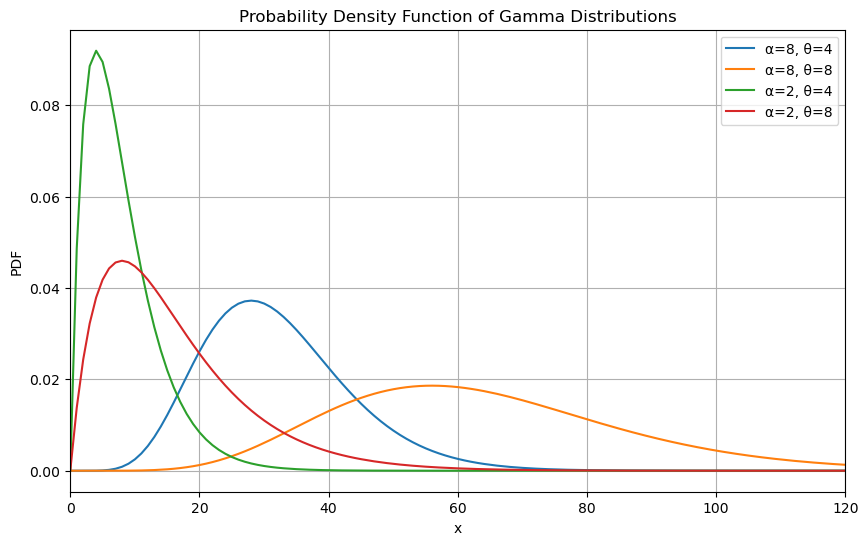

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Define parameters for gamma distribution
alpha_values = [8, 2]  # Shape parameters
theta_values = [4, 8]  # Scale parameters

x = np.linspace(0, 1000, 1000)  # Range of x values for plotting

# Plot PDFs for each combination of parameters
plt.figure(figsize=(10, 6))
for alpha in alpha_values:
    for theta in theta_values:
        # Calculate PDF for gamma distribution
        pdf = gamma.pdf(x, a=alpha, scale=theta)
        
        # Plot the PDF
        plt.plot(x, pdf, label=f'α={alpha}, θ={theta}')

plt.title('Probability Density Function of Gamma Distributions')
plt.xlabel('x')
plt.ylabel('PDF')
plt.legend()
plt.grid(True)
plt.xlim(0, 120)

#plt.savefig('gamma_distributions_dist2.png', dpi=300)

plt.show()

In [ ]:
bins.collected

In [ ]:
day

In [ ]:
a=[5,5,5,5,5,10,10,10,10,10,5,5,5,5,5,10,10,10,10,10,5,5,5,5,5]*9
print(a)

In [ ]:
#tocollect = policy(bins.c, distancesC, 0.84, bins.means, bins.std ,timeLimit=60)
print(bins.c.shape)
print(distance_matrix.shape)
print(bins.means.shape)
print(bins.std.shape)
print(bins.c)
print(distance_matrix)
print(bins.means)
print(bins.std)

In [ ]:
Log

In [ ]:
import matplotlib.pyplot as plt


#Log2 = Log/Log[2,:]
Log2 = np.array(Log)

plt.figure(dpi= 200)
for ll in Log2:
    print(ll[[0,2,5,6]])
    plt.semilogy(['overflows','ncol','days','kgperkm'],ll[[0,2,5,6]],'o-')
plt.legend(policies)
plt.savefig("summary.pdf", bbox_inches='tight')
files.download("summary.pdf")
plt.savefig("summary.png", bbox_inches='tight')
files.download("summary.png")

plt.figure(dpi= 200)
for ll in Log2:
    plt.semilogy(['overflows','kg','ncol','kg lost','km','days','kgperkm','time'],ll)
    print(ll)
plt.legend(policies)
plt.savefig("full.pdf", bbox_inches='tight')
files.download("full.pdf")
plt.savefig("full.png", bbox_inches='tight')
files.download("full.png")

plt.figure(dpi= 200)
for ll in Log2:
    plt.plot(ll[0],ll[6],'+')
plt.ylabel('kgperkm')
plt.xlabel('overflows')
plt.legend(policies)
plt.savefig("comp.pdf", bbox_inches='tight')
files.download("comp.pdf")
plt.savefig("comp.png", bbox_inches='tight')
files.download("comp.png")

In [ ]:
Log